# VERİNİN TEMİZLENMESİ SÜRECİ 


In [103]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import skew
from pandas.api.types import is_numeric_dtype



In [104]:
df = pd.read_parquet("steam.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83560 entries, 0 to 83559
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   AppID                       83560 non-null  int64  
 1   Name                        83554 non-null  object 
 2   Release date                83560 non-null  object 
 3   Estimated owners            83560 non-null  object 
 4   Peak CCU                    83560 non-null  int64  
 5   Required age                83560 non-null  int64  
 6   Price                       83560 non-null  float64
 7   DLC count                   83560 non-null  int64  
 8   About the game              80123 non-null  object 
 9   Supported languages         83560 non-null  object 
 10  Full audio languages        83560 non-null  object 
 11  Reviews                     9716 non-null   object 
 12  Header image                83560 non-null  object 
 13  Website                     390

In [105]:
# Eksik değer kontrolü
print("Eksik değerler: \n")
df.isna().sum().sort_values(ascending=False).head(15)

Eksik değerler: 



Score rank        83516
Metacritic url    79650
Reviews           73844
Notes             70845
Website           44506
Support url       42544
Tags              19986
Support email     13319
Movies             6300
Categories         4456
Publishers         3705
Developers         3457
About the game     3437
Genres             3425
Screenshots        1926
dtype: int64

## Bilgi Kazancı Kontrolü
Bilgi kazancı çok az olan sütunları çıkaralım.

In [106]:

zero_age_count = (df['Required age'] == 0).sum()
print(f"Required age'deki 0 olan değerlerin sayısı: {zero_age_count}")
zero_metacriticscore_count = (df['Metacritic score'] == 0).sum()
print(f"Metacritic score'daki 0 olan değerlerin sayısı: {zero_metacriticscore_count}")
zero_user_score_count = (df['User score'] == 0).sum()
print(f"User score'daki 0 olan değerlerin sayısı: {zero_user_score_count}")
zero_peak_ccu_count = (df['Peak CCU'] == 0).sum()
print(f"Peak ccu'daki 0 olan değerlerin sayısı: {zero_peak_ccu_count}")
zero_dlc_count = (df['DLC count'] == 0).sum()
print(f"Dlc count'daki 0 olan değerlerin sayısı: {zero_dlc_count}")
zero_rec_count = (df['Recommendations'] == 0).sum()
print(f"Recommendations'daki 0 olan değerlerin sayısı: {zero_rec_count}")
# Hem Positive hem Negative 0 olan satırları bul
both_zero_mask = (df['Positive'] == 0) & (df['Negative'] == 0 & (df['Average playtime two weeks'] == 0) & (df['Average playtime forever'] == 0))
both_zero_count = both_zero_mask.sum()
print(f"Hem Positive hem Negative hem de Average palay time'ları 0 olan oyun sayısı: {both_zero_count:,} ({both_zero_count/len(df)*100:.2f}%)")
zero_ach_count = (df['Average playtime forever'] == 0).sum()
print(f"Average playtime forever'daki 0 olan değerlerin sayısı: {zero_ach_count}")
zero_ach_count = (df['Average playtime two weeks'] == 0).sum()
print(f"Average playtime two weeks'daki 0 olan değerlerin sayısı: {zero_ach_count}")

# Bu satırları veri çerçevesinden çıkar
df = df[~both_zero_mask].copy()
print(f"\nTemizlenmiş dataset boyutu: {df.shape}")



Required age'deki 0 olan değerlerin sayısı: 81930
Metacritic score'daki 0 olan değerlerin sayısı: 79650
User score'daki 0 olan değerlerin sayısı: 83516
Peak ccu'daki 0 olan değerlerin sayısı: 61189
Dlc count'daki 0 olan değerlerin sayısı: 71798
Recommendations'daki 0 olan değerlerin sayısı: 69837
Hem Positive hem Negative hem de Average palay time'ları 0 olan oyun sayısı: 20,053 (24.00%)
Average playtime forever'daki 0 olan değerlerin sayısı: 68656
Average playtime two weeks'daki 0 olan değerlerin sayısı: 81512

Temizlenmiş dataset boyutu: (63507, 39)


In [107]:
# Çok fazla eksik değer olanları ve popülerlik 
# tahminindeki bilgi kazancı az olan öznitelikleri tablodan çıkardık.
df = df.drop(columns=["Score rank", "Metacritic url", "Reviews", "Notes", 
                      "Website", "Support url", "Name", "Support email", 
                      "Header image", "Movies", "Screenshots", 
                      "About the game", "Full audio languages", "Windows", 
                      "Linux", "Mac", "Metacritic score", "User score", "Required age",
                      "Peak CCU", "DLC count", "Supported languages", "Recommendations",
                      "AppID"
                      ])

In [108]:
# Kategorik sütunlardaki boş veirleri uygun olarak dolduralım
df["Tags"] = df["Tags"].fillna("Unknown")
df["Categories"] = df["Categories"].fillna("Unknown") 
df["Publishers"] = df["Publishers"].fillna("Unknown Publisher")
df["Developers"] = df["Developers"].fillna("Unknown Developer")
df["Genres"] = df["Genres"].fillna("Unknown")

def clean_developer_and_publishers(dev):
    dev = dev.strip().lower()  # Baş/son boşlukları sil ve küçük harfe çevir
    dev = dev.replace('.', '')  # Noktaları çıkar

    # Şirket tipi keyword'lerini temizle (öncesinde varsa virgül de)
    for keyword in ['llc', 'ltd', 'inc']:
        # Eğer keyword geçiyorsa
        if keyword in dev:
            # Öncesinde virgül ve boşluk varsa çıkar
            dev = dev.replace(f', {keyword}', '')
            dev = dev.replace(f' {keyword}', '')
            dev = dev.replace(f',{keyword}', '')
            dev = dev.replace(keyword, '')  # Kalan varsa onu da çıkar

    return dev.strip()

# Uygula
df['Developers'] = df['Developers'].apply(clean_developer_and_publishers)
df['Publishers'] = df['Publishers'].apply(clean_developer_and_publishers)

In [109]:
df.isna().sum().sort_values(ascending=False).head(3)

Release date        0
Estimated owners    0
Price               0
dtype: int64

In [110]:
df.to_parquet("cleaned_data.parquet", index=False)

# EDA(Exploratory Data Analysis)

In [111]:
df = pd.read_parquet("cleaned_data.parquet")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63507 entries, 0 to 63506
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Release date                63507 non-null  object 
 1   Estimated owners            63507 non-null  object 
 2   Price                       63507 non-null  float64
 3   Positive                    63507 non-null  int64  
 4   Negative                    63507 non-null  int64  
 5   Achievements                63507 non-null  int64  
 6   Average playtime forever    63507 non-null  int64  
 7   Average playtime two weeks  63507 non-null  int64  
 8   Median playtime forever     63507 non-null  int64  
 9   Median playtime two weeks   63507 non-null  int64  
 10  Developers                  63507 non-null  object 
 11  Publishers                  63507 non-null  object 
 12  Categories                  63507 non-null  object 
 13  Genres                      635

## Verilerin henüz işlenmemiş halleri

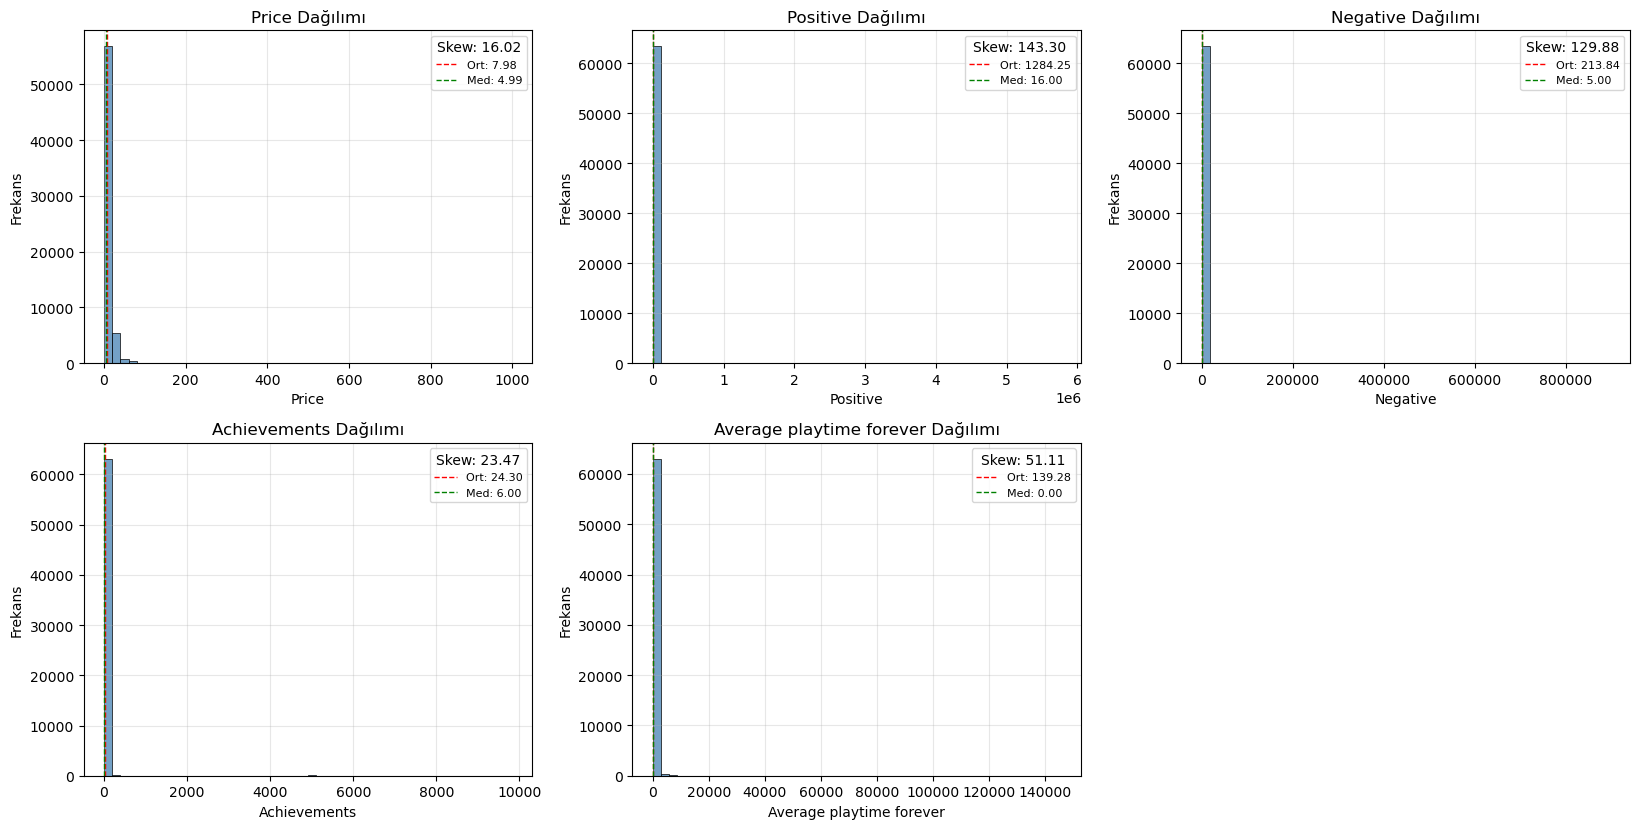

In [112]:

# Sadece istenen sütunların grafikleri
columns_of_interest = ['Price', 'Positive', 'Negative', 'Achievements', 'Average playtime forever']
present = [c for c in columns_of_interest if c in df.columns]

n = len(present)
cols_per_row = 3
rows = int(np.ceil(n / cols_per_row))
fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5.5, rows * 4.2))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(present):
    ax = axes[i]
    s = df[col].dropna()

    if is_numeric_dtype(s):
        # Sayısal -> histogram + ort/med çizgileri
        sns.histplot(s, bins=50, kde=False, ax=ax, color='steelblue', edgecolor='black')
        mean_v, med_v = s.mean(), s.median()
        ax.axvline(mean_v, color='red', linestyle='--', linewidth=1, label=f"Ort: {mean_v:.2f}")
        ax.axvline(med_v, color='green', linestyle='--', linewidth=1, label=f"Med: {med_v:.2f}")
        try:
            skv = skew(s)
            lg = ax.legend(fontsize=8)
            if lg:
                lg.set_title(f"Skew: {skv:.2f}")
        except Exception:
            ax.legend(fontsize=8)
    else:
        # Kategorik -> countplot
        order = s.value_counts().index
        sns.countplot(x=s, order=order, ax=ax, color='steelblue', edgecolor='black')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        # Çubukların üzerine sayıları yazalım
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x()+p.get_width()/2, p.get_height()),
                        ha='center', va='bottom', fontsize=7)

    ax.set_title(f"{col} Dağılımı")
    ax.set_xlabel(col)
    ax.set_ylabel('Frekans')
    ax.grid(alpha=0.3)

# Kullanılmayan eksenleri gizle
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


## Korelasyon Analizi

Developers ve Publishers sütunları kendi içerisinde virgüllerle ayrılmış değerler içeriyor. Buna rağmen %67 oranında aynı değer olması gerçek korelasyonun çok daha fazla olduğu anlamına geliyor. Bu yüzden Publisher sütnunu çıkarıyoruz.

In [113]:
# Kaç satırda developer ve publisher aynı?
same_count = (df['Developers'] == df['Publishers']).sum()
total_count = len(df)
print(f"Developer ve Publisher aynı olan satır sayısı: {same_count} / {total_count}")
print(f"Oran: {same_count/total_count:.2%}")


Developer ve Publisher aynı olan satır sayısı: 43042 / 63507
Oran: 67.78%


In [114]:
df = df.drop(columns=["Publishers"])

Sayısal değerlerin korelasyon matrisinde korelasyonu yüksek olan özellikler içerisinde eleme yaptık.

Saved full correlation matrix to 'correlation_matrix.csv' (8 x 8)


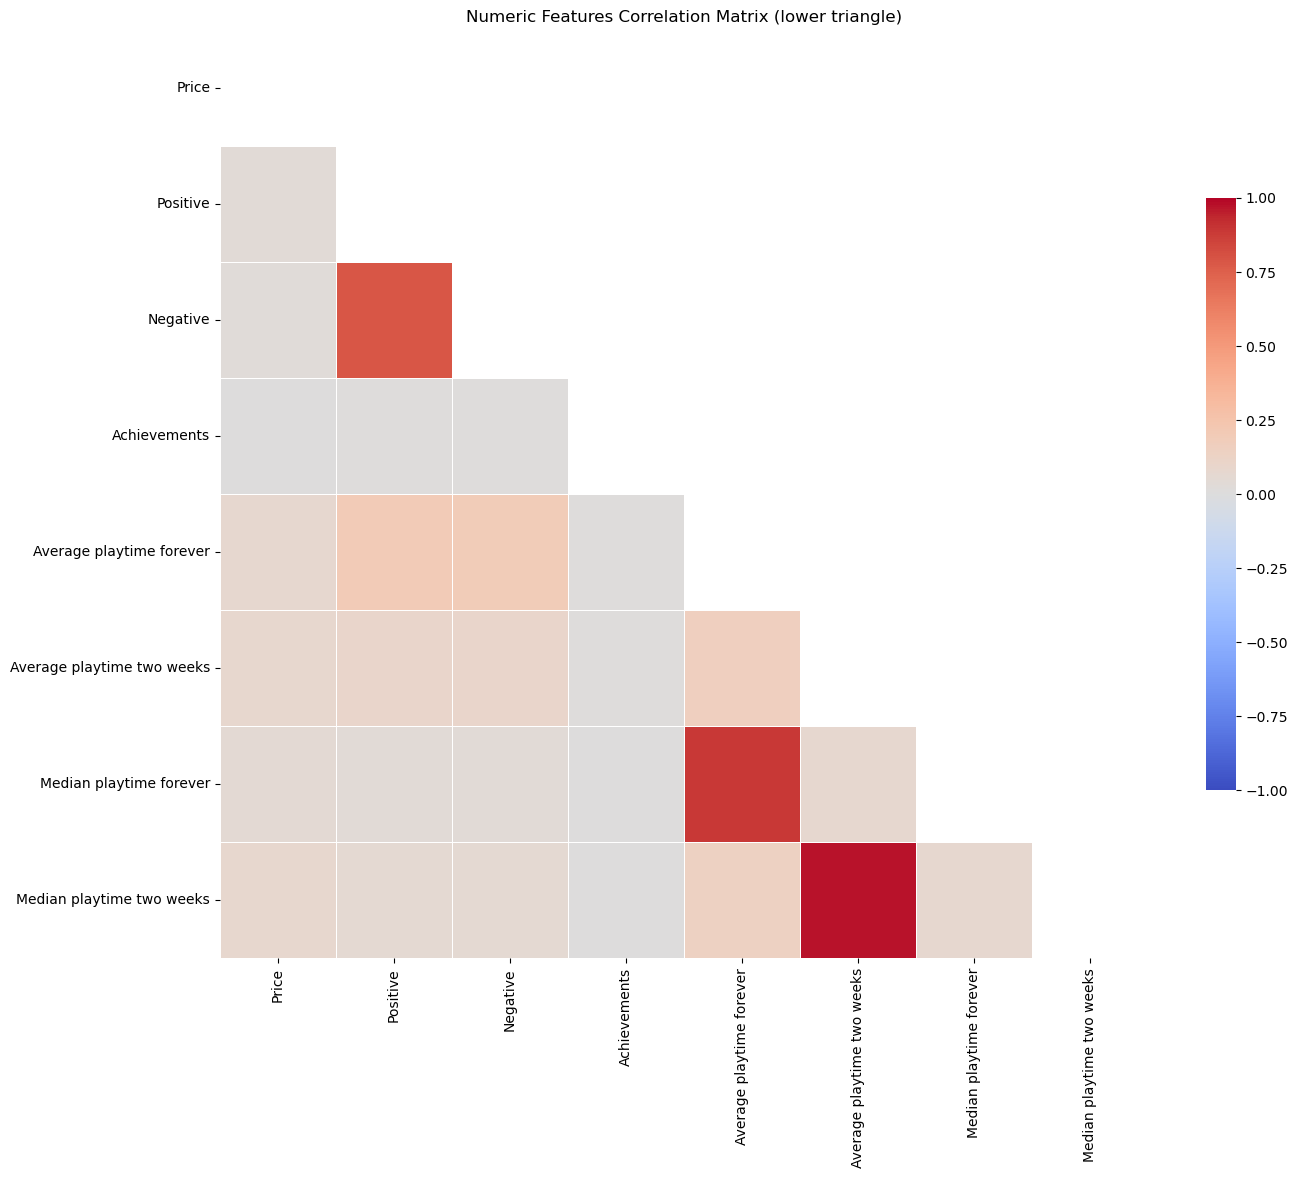

In [115]:
# Full numeric correlation matrix + heatmap + top correlated pairs

# Select numeric columns and compute correlation
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_columns].corr()

# Save full correlation matrix to CSV
corr.to_csv('correlation_matrix.csv')
print(f"Saved full correlation matrix to 'correlation_matrix.csv' ({corr.shape[0]} x {corr.shape[1]})")

# Plot lower-triangle heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(14, 12))
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={'shrink': .6})
plt.title('Numeric Features Correlation Matrix (lower triangle)')
plt.tight_layout()
plt.show()

# Extract top correlated pairs (absolute value) excluding self-correlations
corr_unstack = corr.abs().unstack()
corr_unstack = corr_unstack[corr_unstack.index.get_level_values(0) != corr_unstack.index.get_level_values(1)]
corr_unstack = corr_unstack.drop_duplicates().sort_values(ascending=False)

# Prepare DataFrame of top correlations
top_n = 50
top_corr = (corr_unstack.reset_index()
            .rename(columns={'level_0': 'feature_1', 'level_1': 'feature_2', 0: 'abs_corr'})
            .sort_values(by='abs_corr', ascending=False).head(top_n))

# Save top correlations to CSV
top_corr.to_csv('top_correlations.csv', index=False)

# Also list very high correlations (>= 0.80)
high_thresh = 0.80
high_pairs = top_corr[top_corr['abs_corr'] >= high_thresh]

In [116]:
df = df.drop(columns=["Median playtime two weeks", "Median playtime forever"])

Average playtime forever sütununda çok fazla sıfır değer olduğu için binary dönüşüm yaptık. Average playtime two weeks için ise bu oran çok daha yüksek olduğu için sütunu direkt çıkardık.

In [117]:
# Playtime sütunlarından binary özellikler üretelim
df['Average playtime forever'] = (df['Average playtime forever'] > 0).astype(int)
df['Average playtime two weeks'] = (df['Average playtime two weeks'] > 0).astype(int)

# Oranları görelim
forever_ratio = df['Average playtime forever'].mean() * 100
recent_ratio = df['Average playtime two weeks'].mean() * 100

print(f"Oyunların %{forever_ratio:.1f}'i en az 1 kez oynanmış.")
print(f"Oyunların %{recent_ratio:.1f}'i son 2 haftada oynanmış.")


Oyunların %23.1'i en az 1 kez oynanmış.
Oyunların %3.2'i son 2 haftada oynanmış.


In [118]:
df = df.drop(columns=["Average playtime two weeks"])

## Outlier Analizi

Price için dağılımlara bakıp anormal derecede uç değerleri attık.

In [119]:

# Fiyat aralıklarını belirle (örnek: 0-5$, 5-10$, 10-20$, ...)
bins = [0, 5, 10, 20, 50, 100, 200, 500, 1000]  
labels = [f"${bins[i]}-${bins[i+1]}" for i in range(len(bins)-1)]

# Fiyatları aralıklara ayır
df['Price_range'] = pd.cut(df['Price'], bins=bins, labels=labels, include_lowest=True)

# Her aralıktaki oyun sayısı
price_counts = df['Price_range'].value_counts().sort_index()
print(price_counts)


Price_range
$0-$5         34678
$5-$10        14420
$10-$20       10773
$20-$50        3168
$50-$100        423
$100-$200        41
$200-$500         3
$500-$1000        1
Name: count, dtype: int64


In [120]:
# --- Remove very-rare high-price bins ($200-$500 and $500-$1000)
# These correspond to the bottom two rare Price_range categories you listed (3 rows + 1 row).
price_to_drop = ["$100-$200","$200-$500", "$500-$1000"]

before_len = len(df)
mask = df['Price_range'].isin(price_to_drop)
removed_count = int(mask.sum())
# Drop them
if removed_count > 0:
    df = df[~mask].copy()

print(f"Removed rows in {price_to_drop}: {removed_count:,}")
print(f"New total rows: {len(df):,} (was {before_len:,})")

# Recompute and print Price_range counts
price_counts = df['Price_range'].value_counts().sort_index()
print('\nUpdated Price_range counts:')
print(price_counts)
df = df.drop(columns=["Price_range"])


Removed rows in ['$100-$200', '$200-$500', '$500-$1000']: 45
New total rows: 63,462 (was 63,507)

Updated Price_range counts:
Price_range
$0-$5         34678
$5-$10        14420
$10-$20       10773
$20-$50        3168
$50-$100        423
$100-$200         0
$200-$500         0
$500-$1000        0
Name: count, dtype: int64


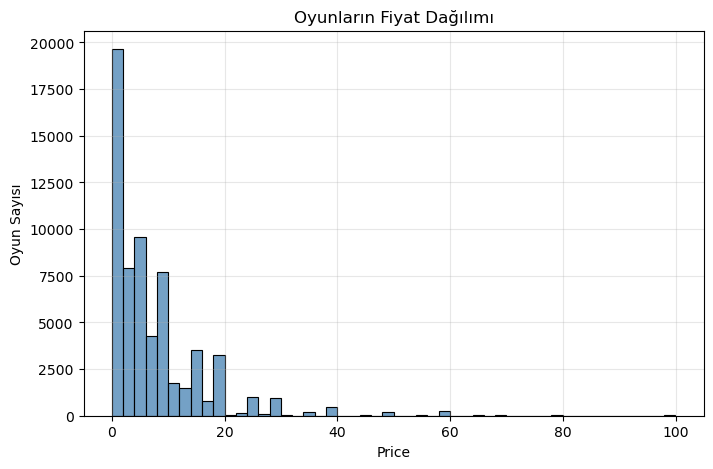

In [121]:

plt.figure(figsize=(8,5))

# Histogram
sns.histplot(df['Price'], bins=50, kde=False, color='steelblue', edgecolor='black')
plt.xlabel('Price')
plt.ylabel('Oyun Sayısı')
plt.title('Oyunların Fiyat Dağılımı')
plt.grid(alpha=0.3)
plt.show()


Release date için bir tane geçersiz değer tesipt edip çıkardık. Ardından kategorik olan veriyi ay, yıl, çeyrek ve mevsime göre numeric hale getirdik.

In [122]:
# Release Date analizi yapalım
print(f"\nToplam benzersiz değer: {df['Release date'].nunique()}")
print(f"\nİlk 3 örnek:")
print(df['Release date'].value_counts().head(3))

# NaN kontrolü
print(f"\n\nBoş değer var mı? {df['Release date'].isna().sum()} ({df['Release date'].isna().sum()/len(df)*100:.2f}%)")



Toplam benzersiz değer: 4371

İlk 3 örnek:
Release date
Jan 17, 2020    76
Sep 14, 2018    69
Oct 15, 2020    69
Name: count, dtype: int64


Boş değer var mı? 0 (0.00%)


In [123]:
# Release Date'i datetime'a çevirelim ve feature'lar çıkaralım
import datetime

# Tarihleri datetime'a çevir
df['release_datetime'] = pd.to_datetime(df['Release date'], format='%b %d, %Y', errors='coerce')

# Başarısız dönüşümleri kontrol et
failed_conversions = df['release_datetime'].isna().sum()
print(f" Dönüştürülemeyen tarih sayısı: {failed_conversions} ({failed_conversions/len(df)*100:.2f}%)")

if failed_conversions > 0:
    # Geçersiz tarihleri sil
    df = df[df['release_datetime'].notna()].copy()
    print(f" Yeni veri boyutu: {df.shape}")

# 1. Yıl (2020, 2021, 2022, 2023, ...)
df['release_year'] = df['release_datetime'].dt.year

# Mantıksız yılları temizle (gelecek veya çok eski tarihler)
invalid_years = df[(df['release_year'] > 2023) | (df['release_year'] < 1990)].shape[0]
if invalid_years > 0:
    df = df[(df['release_year'] <= 2023) & (df['release_year'] >= 1990)].copy()

# 2. Ay (1-12)
df['release_month'] = df['release_datetime'].dt.month

# 3. Çeyrek (Q1, Q2, Q3, Q4)
df['release_quarter'] = df['release_datetime'].dt.quarter

# 4. Oyunun yaşı (2025'ten kaç yıl önce çıktı)
current_year = 2025
df['game_age_years'] = current_year - df['release_year']

# 5. Mevsim (0=Kış, 1=İlkbahar, 2=Yaz, 3=Sonbahar)
def get_season(month):
    if pd.isna(month):
        return -1  # Unknown için
    if month in [12, 1, 2]:
        return 0  # Kış
    elif month in [3, 4, 5]:
        return 1  # İlkbahar
    elif month in [6, 7, 8]:
        return 2  # Yaz
    else:
        return 3  # Sonbahar

df['release_season'] = df['release_month'].apply(get_season)

# İstatistikler
print("\n Yıl Dağılımı:")
print(df['release_year'].value_counts().sort_index(ascending=False).head(10))

print("\n\n Ay Dağılımı:")
month_names = ['Ocak', 'Şubat', 'Mart', 'Nisan', 'Mayıs', 'Haziran', 
               'Temmuz', 'Ağustos', 'Eylül', 'Ekim', 'Kasım', 'Aralık']
month_dist = df['release_month'].value_counts().sort_index()
for month, count in month_dist.items():
    if not pd.isna(month):
        print(f"{int(month):2}. {month_names[int(month)-1]:10} {count:,} oyun")

print("\n\n Mevsim Dağılımı:")
season_names = {0: 'Kış', 1: 'İlkbahar', 2: 'Yaz', 3: 'Sonbahar', -1: 'Unknown'}
for season, count in df['release_season'].value_counts().sort_index().items():
    print(f"{season_names[season]:10} {count:,} oyun")

print("\n\n Oyun Yaşı İstatistikleri:")
print(df['game_age_years'].describe())

# Orijinal sütunları kaldır
df = df.drop(columns=['Release date', 'release_datetime'])

print(f"5 yeni feature eklendi: release_year, release_month, release_quarter, game_age_years, release_season")
print(f" Yeni veri boyutu: {df.shape}")
print(f" Toplam feature sayısı: {df.shape[1]}")


 Dönüştürülemeyen tarih sayısı: 118 (0.19%)
 Yeni veri boyutu: (63344, 12)

 Yıl Dağılımı:
release_year
2023    6079
2022    7476
2021    9219
2020    8661
2019    7123
2018    7827
2017    6204
2016    4381
2015    2666
2014    1617
Name: count, dtype: int64


 Ay Dağılımı:
 1. Ocak       4,417 oyun
 2. Şubat      4,829 oyun
 3. Mart       5,386 oyun
 4. Nisan      5,070 oyun
 5. Mayıs      5,374 oyun
 6. Haziran    4,709 oyun
 7. Temmuz     5,184 oyun
 8. Ağustos    5,662 oyun
 9. Eylül      5,801 oyun
10. Ekim       6,362 oyun
11. Kasım      5,778 oyun
12. Aralık     4,772 oyun


 Mevsim Dağılımı:
Kış        14,018 oyun
İlkbahar   15,830 oyun
Yaz        15,555 oyun
Sonbahar   17,941 oyun


 Oyun Yaşı İstatistikleri:
count    63344.000000
mean         5.940610
std          2.891795
min          2.000000
25%          4.000000
50%          6.000000
75%          8.000000
max         28.000000
Name: game_age_years, dtype: float64
5 yeni feature eklendi: release_year, release_month, relea

Achievements değerlerindeki dengesizliği ortadan kaldırmak için veriyi 5 farklı kategoriye ayırdık.

  Kategori  Oyun Sayısı  Oran (%)
0        0        28565     45.10
1        1         8659     13.67
2        2         9957     15.72
3        3         8071     12.74
4        4         8092     12.77


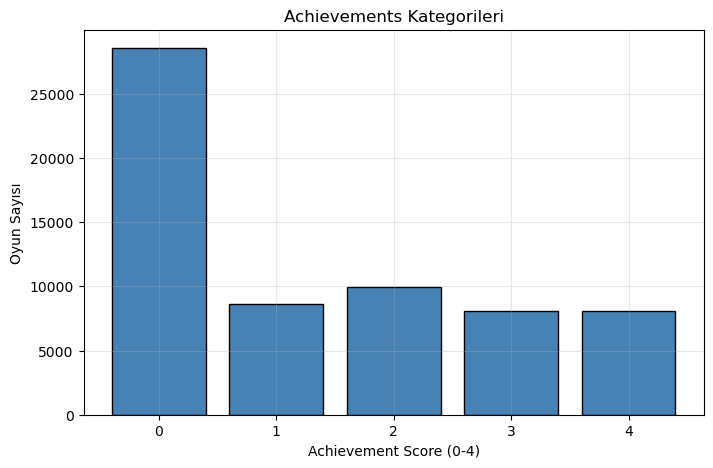

In [124]:

# Achievements serisi
ach = df['Achievements']

# Kategorileri ve sınırları belirleyelim
bins = [-1, 0, 10, 20, 35, ach.max()]
labels = [0, 1, 2, 3, 4]  # 0=hiç, 1=düşük, 2=orta, 3=yüksek, 4=çok yüksek

# Kategori sütunu oluştur
df['Achievements'] = pd.cut(ach, bins=bins, labels=labels, right=True)

# Sayıları ve yüzdeleri görelim
score_counts = df['Achievements'].value_counts().sort_index()
score_percent = (score_counts / len(df) * 100).round(2)

achievement_table = pd.DataFrame({
    'Kategori': score_counts.index,
    'Oyun Sayısı': score_counts.values,
    'Oran (%)': score_percent.values
})

print(achievement_table)

# Histogramla görselleştirelim
plt.figure(figsize=(8,5))
plt.bar(score_counts.index.astype(str), score_counts.values, color='steelblue', edgecolor='black')
plt.xlabel('Achievement Score (0-4)')
plt.ylabel('Oyun Sayısı')
plt.title('Achievements Kategorileri')
plt.grid(alpha=0.3)
plt.show()


## Pozitif Yorum Dağılımı

Pozitif yorum sayılarının dağılımını grafik yerine metin olarak özetliyoruz. Aşağıda 10 eşit aralıklı bölmede (bin) her aralıkta kaç oyun olduğu ve yüzde karşılıkları yer alır. Gerekirse bin sayısı değiştirilebilir.


In [125]:

# Pozitif yorumların metinsel dağılım özeti

series = df['Positive'].dropna()
bins = 10  # gerekirse değiştirilebilir
counts, edges = np.histogram(series, bins=bins)
total = int(counts.sum())

print(f"Toplam oyun: {total}")
print("Aralık -> Adet (Yüzde) | Çubuk")

for i, cnt in enumerate(counts):
    left = int(edges[i])
    # Son aralığı sağ ucu kapsayacak şekilde yazalım
    right = int(edges[i+1]) if i == len(counts)-1 else int(edges[i+1]) - 1
    pct = (cnt/total)*100 if total > 0 else 0
    bar = "█" * max(1, int(pct/2)) if cnt > 0 else ""
    print(f"[{left:,} - {right:,}] -> {cnt:6d} ({pct:5.1f}%) {bar}")


Toplam oyun: 63344
Aralık -> Adet (Yüzde) | Çubuk
[0 - 576,441] ->  63332 (100.0%) █████████████████████████████████████████████████
[576,442 - 1,152,883] ->      8 (  0.0%) █
[1,152,884 - 1,729,325] ->      3 (  0.0%) █
[1,729,326 - 2,305,767] ->      0 (  0.0%) 
[2,305,768 - 2,882,209] ->      0 (  0.0%) 
[2,882,210 - 3,458,651] ->      0 (  0.0%) 
[3,458,652 - 4,035,093] ->      0 (  0.0%) 
[4,035,094 - 4,611,535] ->      0 (  0.0%) 
[4,611,536 - 5,187,977] ->      0 (  0.0%) 
[5,187,978 - 5,764,420] ->      1 (  0.0%) █


## Pozitif Yorum Outlier Temizliği

Pozitif yorum sayılarındaki uç değerleri (outlier) temizlemek için log-dönüşüm (log1p) üzerinde IQR yöntemini kullanıyoruz:

- Log1p(Positive) için Q1 ve Q3 hesaplanır.
- Üst sınır = Q3 + 1.5 × IQR olarak belirlenir ve orijinal ölçeğe expm1 ile geri dönülür.
- Positive bu sınırın üzerindeyse satır çıkarılır.
Bu yaklaşım ağır kuyruklu dağılımlarda aşırı yüksek değerlerin etkisini azaltır ve veri bütünlüğünü korur.


In [126]:
# Outlier temizliği: log-IQR yöntemi

pos = df['Positive'].dropna()
log_pos = np.log1p(pos)
q1, q3 = log_pos.quantile([0.25, 0.75])
iqr = q3 - q1
upper_log = q3 + 1.5 * iqr
upper = np.expm1(upper_log)

before = len(df)
df = df[df['Positive'] <= upper].copy()
removed = before - len(df)

print(f"Outlier üst sınırı (Positive): {int(upper):,}")
print(f"Kaldırılan satır: {removed:,} / Yeni satır sayısı: {len(df):,}")


Outlier üst sınırı (Positive): 6,872
Kaldırılan satır: 1,394 / Yeni satır sayısı: 61,950


## Pozitif Yorumlarda Log Dönüşüm (Öncesi/Sonrası)



Amaç: Sağ kuyruğu baskın olan Positive dağılımını log1p ile daha simetrik hale getirmek ve modellemeye uygun bir ölçeğe taşımak.



- Dönüşüm: log1p(x) = ln(x + 1)

- Beklenti: Çarpıklığın (skewness) azalması, histogramda daha dengeli bir dağılım

- Not: Dönüşüm yalnızca görselleştirme ve bazı modeller için; temel metrik olarak yine orijinal Positive saklıdır.


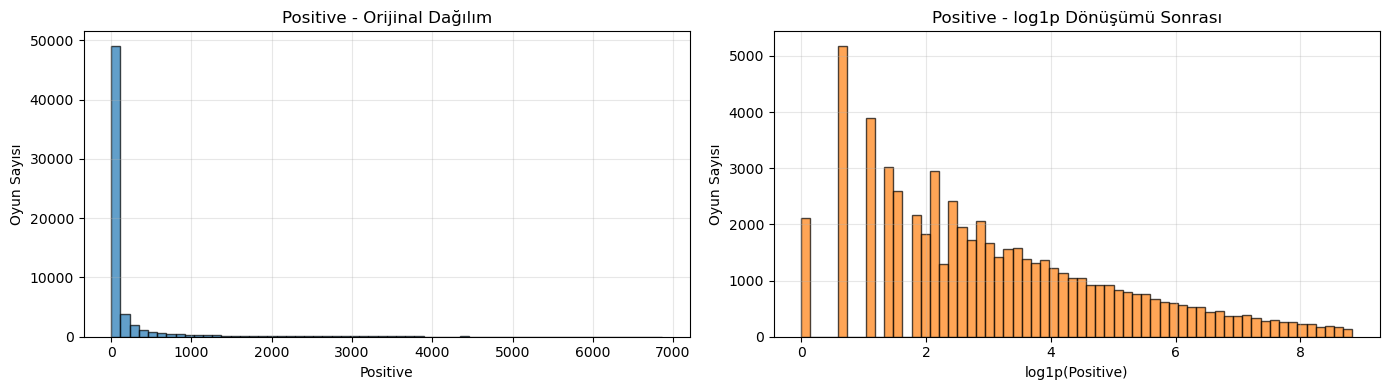

Çarpıklık (skewness):
  Orijinal: 5.56
  log1p    : 0.67


In [127]:
# Positive log transform before/after comparison
from scipy.stats import skew

orig = df['Positive']
log_pos = np.log1p(orig)
df['Positive'] = log_pos  # İstersek modelde kullanılabilir

fig, axes = plt.subplots(1, 2, figsize=(14, 4))
axes[0].hist(orig, bins=60, edgecolor='black', alpha=0.7)
axes[0].set_title('Positive - Orijinal Dağılım')
axes[0].set_xlabel('Positive')
axes[0].set_ylabel('Oyun Sayısı')
axes[0].grid(alpha=0.3)
axes[1].hist(log_pos, bins=60, edgecolor='black', alpha=0.7, color='tab:orange')
axes[1].set_title('Positive - log1p Dönüşümü Sonrası')
axes[1].set_xlabel('log1p(Positive)')
axes[1].set_ylabel('Oyun Sayısı')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()
print('Çarpıklık (skewness):')
print(f'  Orijinal: {skew(orig):.2f}')
print(f'  log1p    : {skew(log_pos):.2f}')


## Negatif Yorum Dağılımı (Metin Özeti)

Negatif yorum sayılarının dağılımını grafik yerine metin olarak özetliyoruz. Aşağıda 10 eşit aralıklı bölmede her aralıkta kaç oyun olduğu ve yüzdeleri yer alır.


In [128]:

# Negatif yorumların metinsel dağılım özeti
series = df['Negative'].dropna()

bins = 10  # gerekirse değiştirilebilir
counts, edges = np.histogram(series, bins=bins)
total = int(counts.sum())

print(f"Toplam oyun: {total}")
print("Aralık -> Adet (Yüzde) | Çubuk")

for i, cnt in enumerate(counts):
    left = int(edges[i])
    # Son aralığı sağ ucu kapsayacak şekilde yazalım
    right = int(edges[i+1]) if i == len(counts)-1 else int(edges[i+1]) - 1
    pct = (cnt/total)*100 if total > 0 else 0
    bar = "█" * max(1, int(pct/2)) if cnt > 0 else ""
    print(f"[{left:,} - {right:,}] -> {cnt:6d} ({pct:5.1f}%) {bar}")

Toplam oyun: 61950
Aralık -> Adet (Yüzde) | Çubuk
[0 - 1,112] ->  61505 ( 99.3%) █████████████████████████████████████████████████
[1,113 - 2,225] ->    327 (  0.5%) █
[2,226 - 3,338] ->     72 (  0.1%) █
[3,339 - 4,452] ->     27 (  0.0%) █
[4,453 - 5,565] ->      7 (  0.0%) █
[5,566 - 6,678] ->      7 (  0.0%) █
[6,679 - 7,792] ->      1 (  0.0%) █
[7,793 - 8,905] ->      2 (  0.0%) █
[8,906 - 10,018] ->      0 (  0.0%) 
[10,019 - 11,133] ->      2 (  0.0%) █


## Negatif Yorum Outlier Temizliği

Negatif yorumlarda log1p üzerinde IQR yöntemini kullanarak üst uç değerleri temizliyoruz:
- Q1, Q3 ve IQR (Q3 - Q1) hesaplanır.

- Üst sınır: Q3 + 1.5 × IQR; orijinal ölçeğe expm1 ile dönülür.

- Negative bu değerin üzerindeyse satır çıkarılır.


In [129]:
# Outlier temizliği: Negative için log-IQR
neg = df['Negative'].dropna()
log_neg = np.log1p(neg)
q1, q3 = log_neg.quantile([0.25, 0.75])
iqr = q3 - q1
upper_log = q3 + 1.5 * iqr
upper = np.expm1(upper_log)

before = len(df)
df = df[df['Negative'] <= upper].copy()
removed = before - len(df)

print(f"Outlier üst sınırı (Negative): {int(upper):,}")
print(f"Kaldırılan satır: {removed:,} / Yeni satır sayısı: {len(df):,}")


Outlier üst sınırı (Negative): 996
Kaldırılan satır: 518 / Yeni satır sayısı: 61,432


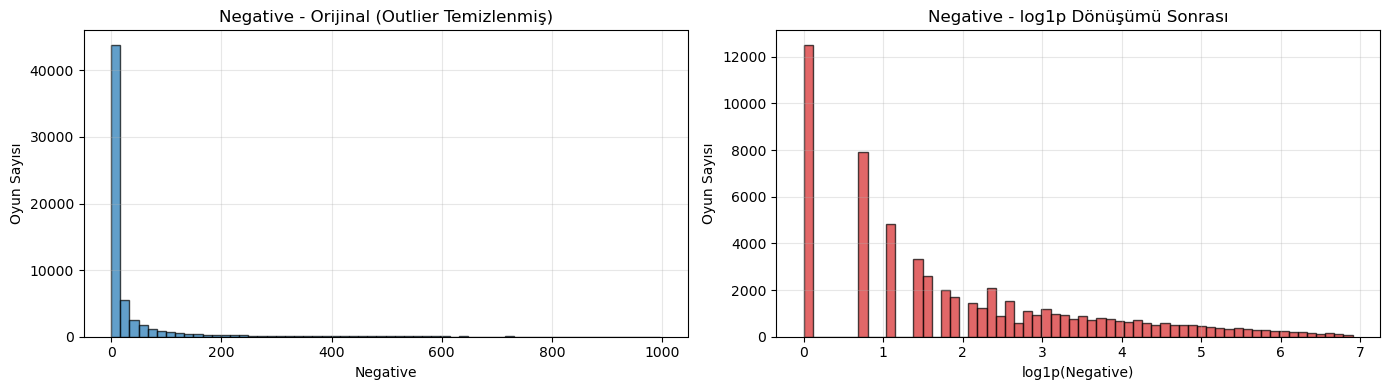

Çarpıklık (skewness):
  Orijinal (temizlenmiş): 4.87
  log1p               : 0.70


In [130]:
# Negative log transform after outlier cleaning

from scipy.stats import skew
orig_neg = df['Negative']
log_neg = np.log1p(orig_neg)
df['Negative'] = log_neg

fig, axes = plt.subplots(1, 2, figsize=(14,4))
axes[0].hist(orig_neg, bins=60, edgecolor='black', alpha=0.7)
axes[0].set_title('Negative - Orijinal (Outlier Temizlenmiş)')
axes[0].set_xlabel('Negative')
axes[0].set_ylabel('Oyun Sayısı')
axes[0].grid(alpha=0.3)
axes[1].hist(log_neg, bins=60, edgecolor='black', alpha=0.7, color='tab:red')
axes[1].set_title('Negative - log1p Dönüşümü Sonrası')
axes[1].set_xlabel('log1p(Negative)')
axes[1].set_ylabel('Oyun Sayısı')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print('Çarpıklık (skewness):')
print(f'  Orijinal (temizlenmiş): {skew(orig_neg):.2f}')
print(f'  log1p               : {skew(log_neg):.2f}')

## Sayısal Değerlerin İşlendikten Sonraki Hali

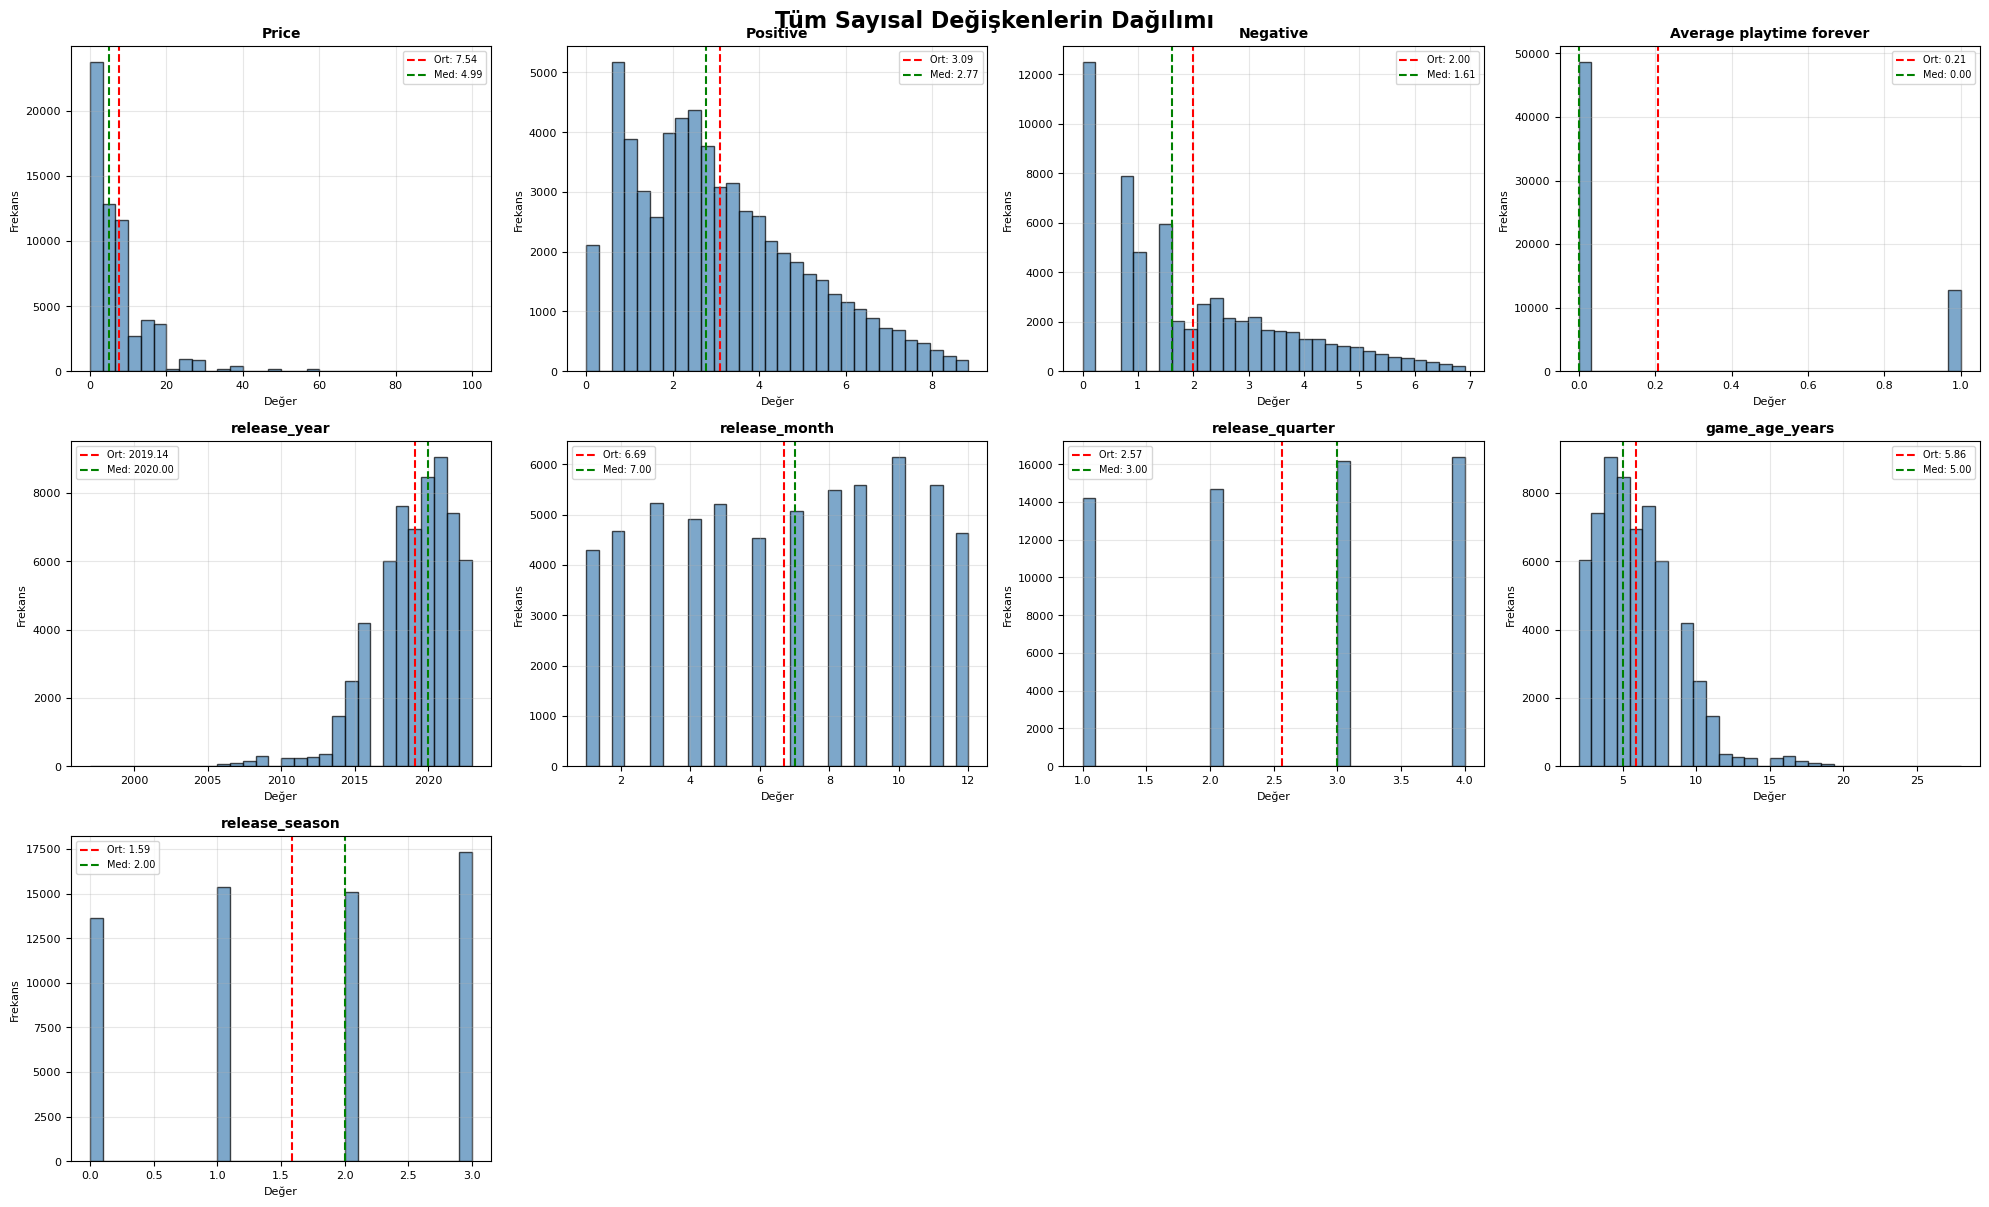


Toplam 9 sayısal değişken görselleştirildi.


In [131]:

# Sayısal sütunları belirle
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()

# Toplam grafik sayısını hesapla
n_cols = 4  # Satır başına 4 grafik
n_rows = int(np.ceil(len(numeric_columns) / n_cols))

# Büyük bir figure oluştur (tüm grafikleri bir pencerede göstermek için)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()  # Düz bir array'e çevir

# Her sayısal değişken için histogram çiz
for idx, col in enumerate(numeric_columns):
    ax = axes[idx]
    
    # Histogram çiz
    ax.hist(df[col].dropna(), bins=30, color='steelblue', alpha=0.7, edgecolor='black')
    
    # Başlık ve etiketler
    ax.set_title(f'{col}', fontsize=10, fontweight='bold')
    ax.set_xlabel('Değer', fontsize=8)
    ax.set_ylabel('Frekans', fontsize=8)
    ax.tick_params(labelsize=8)
    ax.grid(True, alpha=0.3)
    
    # Temel istatistikleri göster
    mean_val = df[col].mean()
    median_val = df[col].median()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=1.5, label=f'Ort: {mean_val:.2f}')
    ax.axvline(median_val, color='green', linestyle='--', linewidth=1.5, label=f'Med: {median_val:.2f}')
    ax.legend(fontsize=7)

# Kullanılmayan subplot'ları gizle
for idx in range(len(numeric_columns), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.suptitle('Tüm Sayısal Değişkenlerin Dağılımı', fontsize=16, fontweight='bold', y=1.002)
plt.show()

print(f"\nToplam {len(numeric_columns)} sayısal değişken görselleştirildi.")

## Kategorik Veirlerin Sayısallaştırılması

Estimated owners için iki aralığın ortalama değerini aldık.

In [132]:
# Orijinal sütunu görelim
print("Orijinal 'Estimated owners' sütunu örnekleri:")
print(df['Estimated owners'].head(), "\n")

# Aralıkları ayır (min ve max)
df[['owners_min', 'owners_max']] = df['Estimated owners'].str.split('-', expand=True)
print("Aralıklar ayrıldı (min ve max):")
print(df[['owners_min', 'owners_max']].head(), "\n")

# Sayısal tipe çevir ve boşlukları temizle
df['owners_min'] = df['owners_min'].str.strip().astype(float)
df['owners_max'] = df['owners_max'].str.strip().astype(float)
print("Sayısal tipe çevrildi:")
print(df[['owners_min', 'owners_max']].head(), "\n")

# Ortalama al
df['Estimated owners numeric'] = df[['owners_min', 'owners_max']].mean(axis=1)
df = df.drop(columns=["owners_min", "owners_max"])
print("Ortalama alınmış sayısal değerler:")
print(df[['Estimated owners', 'Estimated owners numeric']].head())
#df = df.drop(columns=["Estimated owners"])


Orijinal 'Estimated owners' sütunu örnekleri:
0         0 - 20000
1         0 - 20000
2         0 - 20000
3         0 - 20000
4    50000 - 100000
Name: Estimated owners, dtype: object 

Aralıklar ayrıldı (min ve max):
  owners_min owners_max
0         0       20000
1         0       20000
2         0       20000
3         0       20000
4     50000      100000 

Sayısal tipe çevrildi:
   owners_min  owners_max
0         0.0     20000.0
1         0.0     20000.0
2         0.0     20000.0
3         0.0     20000.0
4     50000.0    100000.0 

Ortalama alınmış sayısal değerler:
  Estimated owners  Estimated owners numeric
0        0 - 20000                   10000.0
1        0 - 20000                   10000.0
2        0 - 20000                   10000.0
3        0 - 20000                   10000.0
4   50000 - 100000                   75000.0


Estimated owners'ı target value olarak kullanacağız. Bu yüzden 3 farklı sınıfa ayırdık.(Low - Medium - High)

In [133]:

# Veriyi kontrol et
print("Unique Estimated owners değerleri:")
print(df['Estimated owners'].unique())
print("\nValue counts:")
print(df['Estimated owners'].value_counts())

# Target oluştur
def categorize_owners(owner_range):
    """
    Estimated owners aralığını 3 kategoriye ayırır
    Low: 0 - 20000
    Medium: 20000 - 50000
    High: 50000+
    """
    if pd.isna(owner_range):
        return None
    
    owner_str = str(owner_range).strip()
    
    # Düşük popülerlik
    if owner_str in ['0 - 0', '0 - 20000']:
        return 'Low'
    
    # Orta popülerlik
    elif owner_str == '20000 - 50000':
        return 'Medium'
    
    # Yüksek popülerlik (50000'den büyük her şey)
    else:
        # Alt sınırı kontrol et
        try:
            lower_bound = int(owner_str.split(' - ')[0])
            if lower_bound >= 50000:
                return 'High'
            else:
                return 'Medium'  # Emin değilsek Medium
        except:
            return None

# Kategorik target
y_categorical = df['Estimated owners'].apply(categorize_owners)

# Sayısal target (ML modelleri için)
label_mapping = {'Low': 0, 'Medium': 1, 'High': 2}
y = y_categorical.map(label_mapping)

# Missing değerleri kontrol et
print(f"\nMissing values: {y.isna().sum()}")

# Dağılımı kontrol et
print("\n=== TARGET DAĞILIMI ===")
print("\nKategorik:")
print(y_categorical.value_counts())
print(f"\nYüzdeler:")
print(y_categorical.value_counts(normalize=True) * 100)

print("\n\nSayısal:")
print(y.value_counts().sort_index())

# Missing varsa temizle
if y.isna().sum() > 0:
    print(f"\n⚠️ {y.isna().sum()} adet missing değer var, temizleniyor...")
    df_clean = df[y.notna()].copy()
    y_clean = y[y.notna()].copy()
    print(f"✅ Temiz veri sayısı: {len(y_clean)}")
else:
    df_clean = df.copy()
    y_clean = y.copy()

Unique Estimated owners değerleri:
['0 - 20000' '50000 - 100000' '20000 - 50000' '200000 - 500000'
 '100000 - 200000' '500000 - 1000000' '1000000 - 2000000'
 '5000000 - 10000000' '2000000 - 5000000' '10000000 - 20000000']

Value counts:
Estimated owners
0 - 20000              45099
20000 - 50000           7753
50000 - 100000          3854
100000 - 200000         2458
200000 - 500000         1779
500000 - 1000000         396
1000000 - 2000000         74
5000000 - 10000000        11
2000000 - 5000000          7
10000000 - 20000000        1
Name: count, dtype: int64

Missing values: 0

=== TARGET DAĞILIMI ===

Kategorik:
Estimated owners
Low       45099
High       8580
Medium     7753
Name: count, dtype: int64

Yüzdeler:
Estimated owners
Low       73.412879
High      13.966662
Medium    12.620458
Name: proportion, dtype: float64


Sayısal:
Estimated owners
0    45099
1     7753
2     8580
Name: count, dtype: int64


Farklı genres türlerinin verideki dağılımlarına bakarak ayırt edici olabilecek değerleri seçerek one-hot-encoding yaptık.

In [134]:
# Genres'lerin ayırt ediciliğini analiz edelim
# orta seviye yaygınlıktaki genres'leri seçelim

total_games = len(df[df['Genres'] != 'Unknown'])
all_genres_filtered = df[df['Genres'] != 'Unknown']['Genres'].str.split(',').explode()
all_genres_filtered = all_genres_filtered.str.strip()
genres_counts = all_genres_filtered.value_counts()

# Her genres'in yüzde dağılımını hesapla
genres_percentages = (genres_counts / total_games * 100).round(2)

print("Genres'lerin yaygınlığı:")
print("="*60)
for i, (genres, pct) in enumerate(genres_percentages.head(30).items(), 1):
    bar = "█" * int(pct / 2)  # Her 2% için bir blok
    print(f"{i:2}. {genres:25} {pct:5.1f}% {bar}")


Genres'lerin yaygınlığı:
 1. Indie                      72.3% ████████████████████████████████████
 2. Action                     42.5% █████████████████████
 3. Casual                     40.5% ████████████████████
 4. Adventure                  39.3% ███████████████████
 5. Strategy                   19.7% █████████
 6. Simulation                 19.6% █████████
 7. RPG                        17.3% ████████
 8. Early Access               12.3% ██████
 9. Free to Play                5.2% ██
10. Sports                      4.8% ██
11. Racing                      3.9% █
12. Massively Multiplayer       2.2% █
13. Utilities                   1.1% 
14. Violent                     0.8% 
15. Design & Illustration       0.7% 
16. Animation & Modeling        0.5% 
17. Education                   0.5% 
18. Gore                        0.5% 
19. Video Production            0.3% 
20. Audio Production            0.3% 
21. Software Training           0.3% 
22. Game Development            0.3% 
23. N

In [135]:
# 1. Encode edilecek genre'lar
selected_genres = [
    'Adventure', 'Simulation', 'Strategy', 'RPG', 'Action', 'Casual', 'Indie', 'Sports'
]

print(f"Seçilen {len(selected_genres)} ayırt edici genre:")
print("="*70)
for i, genre in enumerate(selected_genres, 1):
    print(f"{i:2}. {genre}")

# 2. Her genre için binary encoding yap
for genre in selected_genres:
    clean_name = genre.strip().replace(' ', '_').replace('-', '_').replace('&', 'and')
    df[f'genre_{clean_name}'] = df['Genres'].apply(
        lambda x: 0 if x == 'Unknown' else (1 if genre in [g.strip() for g in x.split(',')] else 0)
    )

# 3. "Other" kategorisi: Unknown olmayan ama seçili genre içermeyen oyunlar
def calculate_genre_other(row):
    if row['Genres'] == 'Unknown':
        return 0
    game_genres = [g.strip() for g in row['Genres'].split(',')]
    has_selected_genre = any(g in game_genres for g in selected_genres)
    return 0 if has_selected_genre else 1

df['genre_Other'] = df.apply(calculate_genre_other, axis=1)

# 4. Sonuç istatistikleri
unknown_count = (df['Genres'] == 'Unknown').sum()
genre_columns = [f'genre_{g.strip().replace(" ", "_").replace("-", "_").replace("&", "and")}' for g in selected_genres]
games_with_selected_genres = (df[genre_columns].sum(axis=1) > 0).sum()

print(f"\n\n Sonuç İstatistikleri:")
print("="*70)
print(f"Unknown genre'li oyunlar: {unknown_count:,} ({unknown_count/len(df)*100:.1f}%)")
print(f"Seçili genre’lerden en az birinde olan: {games_with_selected_genres:,} ({games_with_selected_genres/len(df)*100:.1f}%)")
print(f"Seçili değil ama genre’i olan (Other): {df['genre_Other'].sum():,} ({df['genre_Other'].sum()/len(df)*100:.1f}%)")

# 5. Orijinal Genres sütununu kaldır
df = df.drop(columns=['Genres'])

print(f"\n {len(selected_genres) + 1} yeni genre sütunu eklendi ({len(selected_genres)} seçili + Other)")
print(f" Yeni veri boyutu: {df.shape}")
print(f" Toplam feature sayısı: {df.shape[1]}")


Seçilen 8 ayırt edici genre:
 1. Adventure
 2. Simulation
 3. Strategy
 4. RPG
 5. Action
 6. Casual
 7. Indie
 8. Sports


 Sonuç İstatistikleri:
Unknown genre'li oyunlar: 69 (0.1%)
Seçili genre’lerden en az birinde olan: 60,016 (97.7%)
Seçili değil ama genre’i olan (Other): 1,347 (2.2%)

 9 yeni genre sütunu eklendi (8 seçili + Other)
 Yeni veri boyutu: (61432, 24)
 Toplam feature sayısı: 24


Farklı kategorilerin verideki dağılımlarına bakarak ayırt edici olaiblecek değeri seçerek one-hot-encoding yaptık.

In [136]:
# Categories için önce analiz yapalım

# Tüm kategorileri ayırıp en popülerlerini bulalım
all_categories = df['Categories'].str.split(',').explode()
print(all_categories.nunique())
print("\n\nEn popüler 20 kategori:")
print(all_categories.value_counts().head(20))


41


En popüler 20 kategori:
Categories
Single-player                 57928
Steam Achievements            29758
Steam Cloud                   15464
Full controller support       12950
Multi-player                  11619
Steam Trading Cards            8641
Partial Controller Support     8406
PvP                            7190
Steam Leaderboards             5753
Co-op                          5745
Remote Play Together           5120
Online PvP                     4947
Shared/Split Screen            4655
Shared/Split Screen PvP        3321
Stats                          3012
Online Co-op                   2988
Shared/Split Screen Co-op      2674
Cross-Platform Multiplayer     1693
Remote Play on TV              1643
Includes level editor          1592
Name: count, dtype: int64


In [137]:
# 1. Encode edilecek kategoriler
selected_categories = [
    'Single-player',
    'Multi-player',
    'Co-op',
    'PvP',
    'Online PvP',
    'Full controller support'
]

print(f" Seçilen {len(selected_categories)} ayırt edici kategori:")
print("="*70)
for i, cat in enumerate(selected_categories, 1):
    print(f"{i:2}. {cat}")

# 2. Her kategori için binary encoding yap
for cat in selected_categories:
    clean_name = cat.strip().replace(' ', '_').replace('-', '_').replace('&', 'and')
    df[f'category_{clean_name}'] = df['Categories'].apply(
        lambda x: 0 if x == 'Unknown' else (1 if cat in [c.strip() for c in x.split(',')] else 0)
    )

#  3. "Other" kategorisi: Unknown olmayan ama seçili kategorilere girmeyen oyunlar
def calculate_category_other(row):
    if row['Categories'] == 'Unknown':
        return 0
    game_cats = [c.strip() for c in row['Categories'].split(',')]
    has_selected_cat = any(c in game_cats for c in selected_categories)
    return 0 if has_selected_cat else 1

df['category_Other'] = df.apply(calculate_category_other, axis=1)

# 4. Sonuç istatistikleri
unknown_count = (df['Categories'] == 'Unknown').sum()
category_columns = [f'category_{c.strip().replace(" ", "_").replace("-", "_").replace("&", "and")}' for c in selected_categories]
games_with_selected_cats = (df[category_columns].sum(axis=1) > 0).sum()

print(f"\n\n Sonuç İstatistikleri:")
print("="*70)
print(f"Unknown category’li oyunlar: {unknown_count:,} ({unknown_count/len(df)*100:.1f}%)")
print(f"Seçili kategorilerden en az birine sahip olan: {games_with_selected_cats:,} ({games_with_selected_cats/len(df)*100:.1f}%)")
print(f"Seçili değil ama kategoriye sahip (Other): {df['category_Other'].sum():,} ({df['category_Other'].sum()/len(df)*100:.1f}%)")

# 5. Orijinal Categories sütununu kaldır
df = df.drop(columns=['Categories'])

print(f"\n {len(selected_categories) + 1} yeni category sütunu eklendi ({len(selected_categories)} seçili + Other)")
print(f"Yeni veri boyutu: {df.shape}")
print(f"Toplam feature sayısı: {df.shape[1]}")


 Seçilen 6 ayırt edici kategori:
 1. Single-player
 2. Multi-player
 3. Co-op
 4. PvP
 5. Online PvP
 6. Full controller support


 Sonuç İstatistikleri:
Unknown category’li oyunlar: 891 (1.5%)
Seçili kategorilerden en az birine sahip olan: 60,254 (98.1%)
Seçili değil ama kategoriye sahip (Other): 287 (0.5%)

 7 yeni category sütunu eklendi (6 seçili + Other)
Yeni veri boyutu: (61432, 30)
Toplam feature sayısı: 30


Developer sütunundaki veriler çok dağınık olduğu için her bir sütun özelinde mevcut developerların toplam oyun sayılarının ortalamsını aldık.

In [138]:
# Developers için analiz yapalım

# Tüm developer'ları ayırıp en popülerlerini bulalım
all_devs = df['Developers'].str.split(',').explode()
all_devs = all_devs.str.strip()  # Boşlukları temizle
print("Unique değer sayısı: ", all_devs.nunique())
print("\n\nEn popüler 20 developer:")
print(all_devs.value_counts().head(20))



Unique değer sayısı:  40232


En popüler 20 developer:
Developers
choice of games             155
creobit                     126
laush dmitriy sergeevich    113
sokpop collective            99
hosted games                 94
koei tecmo games co          93
boogygames studios           93
reforged group               89
dnovel                       88
tero lunkka                  87
elephant games               80
blender games                71
atomic fabrik                67
square enix                  66
ripknot systems              62
somer games                  61
rewindapp                    61
sega                         59
cristian manolachi           58
amax interactive             57
Name: count, dtype: int64


In [139]:
# Developer'lar çok dağınık, her birinin çok az oyunu var
# Alternatif: Developer'ın toplam oyun sayısını feature olarak kullan

# Her developer'ın kaç oyunu olduğunu hesapla
dev_counts = df['Developers'].explode().str.strip().value_counts()

# Her oyun için, o oyunun developer'larının ortalama oyun sayısını hesapla
def get_avg_developer_popularity(dev_string):
    if pd.isna(dev_string):
        return 0
    developers = [d.strip() for d in dev_string.split(',')]
    counts = [dev_counts.get(dev, 1) for dev in developers]
    return sum(counts) / len(counts) if counts else 1

df['developer_avg_game_count'] = df['Developers'].apply(get_avg_developer_popularity)

print("Developer popülaritesi (ortalama oyun sayısı) feature'ı oluşturuldu")
print(f"\nİstatistikler:")
print(df['developer_avg_game_count'].describe())

# Orijinal Developers sütununu kaldır
df = df.drop(columns=['Developers'])

print(f"\n Developer sütunu -> 1 sayısal feature'a dönüştürüldü")
print(f"Yeni veri boyutu: {df.shape}")
print("\nÖrnek değerler:")
print(df[['developer_avg_game_count']].head(10))


Developer popülaritesi (ortalama oyun sayısı) feature'ı oluşturuldu

İstatistikler:
count    61432.000000
mean         6.230745
std         15.404438
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max        155.000000
Name: developer_avg_game_count, dtype: float64

 Developer sütunu -> 1 sayısal feature'a dönüştürüldü
Yeni veri boyutu: (61432, 30)

Örnek değerler:
   developer_avg_game_count
0                       1.0
1                       3.0
2                       1.0
3                       1.0
4                       1.0
5                       2.0
6                       2.0
7                       4.0
8                       2.0
9                       3.0


Farklı tag'lerin verideki dağılımlarına bakarak ayırt edici olabilecek özelllikleri seçerek one-hot-encoding yaptık.

In [140]:

# Unknown tag sayısı
unknown_count = (df['Tags'] == 'Unknown').sum()
print(f"\n 'Unknown' tag'li oyun sayısı: {unknown_count} ({unknown_count / len(df) * 100:.2f}%)")

# Tüm tag'leri ayırıp en popülerlerini bulalım
all_tags = df['Tags'].str.split(',').explode()
all_tags = all_tags.str.strip()
unique = all_tags.unique()



 'Unknown' tag'li oyun sayısı: 9 (0.01%)


In [141]:
# Tag'lerin ayırt ediciliğini analiz edelim
# Çok yaygın tag'ler (>%30) ve çok nadir tag'ler (<%1) yerine
# orta seviye yaygınlıktaki tag'leri seçelim

total_games = len(df[df['Tags'] != 'Unknown'])
all_tags_filtered = df[df['Tags'] != 'Unknown']['Tags'].str.split(',').explode()
all_tags_filtered = all_tags_filtered.str.strip()
tag_counts = all_tags_filtered.value_counts()

# Her tag'in yüzde dağılımını hesapla
tag_percentages = (tag_counts / total_games * 100).round(2)

print("Tag'lerin yaygınlığı:")
print("="*60)
for i, (tag, pct) in enumerate(tag_percentages.head(30).items(), 1):
    bar = "█" * int(pct / 2)  # Her 2% için bir blok
    print(f"{i:2}. {tag:25} {pct:5.1f}% {bar}")


Tag'lerin yaygınlığı:
 1. Indie                      63.8% ███████████████████████████████
 2. Singleplayer               50.7% █████████████████████████
 3. Action                     44.2% ██████████████████████
 4. Casual                     43.6% █████████████████████
 5. Adventure                  41.4% ████████████████████
 6. 2D                         27.6% █████████████
 7. Strategy                   21.0% ██████████
 8. Simulation                 20.7% ██████████
 9. RPG                        18.2% █████████
10. Puzzle                     18.0% ████████
11. Atmospheric                16.6% ████████
12. 3D                         15.7% ███████
13. Pixel Graphics             14.5% ███████
14. Early Access               14.5% ███████
15. Colorful                   14.0% ███████
16. Story Rich                 13.4% ██████
17. Cute                       12.6% ██████
18. Arcade                     12.3% ██████
19. Exploration                12.1% ██████
20. Fantasy                

In [142]:
# %12-21 arasındaki ayırt edici tag'leri seçelim
# Simulation, RPG, Puzzle, Atmospheric, 3D, Early Access, Pixel Graphics, 
# Story Rich, Colorful, Cute, Multiplayer gibi

# %12-21 arasındaki tag'leri otomatik olarak seçelim
selected_tags = tag_percentages[(tag_percentages >= 12) & (tag_percentages <= 21)].index.tolist()

print(f"Seçilen {len(selected_tags)} ayırt edici tag (%12-21 arası yaygınlık):")
print("="*70)
for i, tag in enumerate(selected_tags, 1):
    pct = tag_percentages[tag]
    count = tag_counts[tag]
    print(f"{i:2}. {tag:30} {pct:5.1f}% ({count:,} oyun)")

# Her tag için binary encoding yap
for tag in selected_tags:
    # Tag adını temizle (sütun adı için)
    clean_name = tag.strip().replace(' ', '_').replace('-', '_').replace("'", "").replace('&', 'and')
    # Unknown tag'lerde 0, diğerlerinde tag içerip içermediğine bak (virgülle ayrılmış kontrolü)
    df[f'tag_{clean_name}'] = df['Tags'].apply(
        lambda x: 0 if x == 'Unknown' else (1 if tag in [t.strip() for t in x.split(',')] else 0)
    )

# "Other" kategorisi ekle - Unknown olmayan ama seçilen tag'lerde olmayan oyunlar
def calculate_tag_other(row):
    if row['Tags'] == 'Unknown':
        return 0  # Unknown'lar Other'a dahil değil
    # Hiçbir seçili tag'i içermiyorsa Other = 1
    game_tags = [t.strip() for t in row['Tags'].split(',')]
    has_selected_tag = any(tag in game_tags for tag in selected_tags)
    return 0 if has_selected_tag else 1

df['tag_Other'] = df.apply(calculate_tag_other, axis=1)

# İstatistikler
unknown_count = (df['Tags'] == 'Unknown').sum()

print(f"\n\nSonuç İstatistikleri:")
print("="*70)
print(f"Unknown tag'li oyunlar: {unknown_count:,} ({unknown_count/len(df)*100:.1f}%)")
print(f"Tag'i var ama seçili değil (Other): {df['tag_Other'].sum():,} ({df['tag_Other'].sum()/len(df)*100:.1f}%)")

# Orijinal Tags sütununu kaldır
df = df.drop(columns=['Tags'])

print(f"\n {len(selected_tags) + 1} yeni tag sütunu eklendi ({len(selected_tags)} seçili + Other)")
print(f"Yeni veri boyutu: {df.shape}")
print(f"Toplam feature sayısı: {df.shape[1]}")


Seçilen 13 ayırt edici tag (%12-21 arası yaygınlık):
 1. Strategy                        21.0% (12,885 oyun)
 2. Simulation                      20.7% (12,704 oyun)
 3. RPG                             18.2% (11,191 oyun)
 4. Puzzle                          18.0% (11,047 oyun)
 5. Atmospheric                     16.6% (10,218 oyun)
 6. 3D                              15.7% (9,619 oyun)
 7. Pixel Graphics                  14.5% (8,927 oyun)
 8. Early Access                    14.5% (8,897 oyun)
 9. Colorful                        14.0% (8,610 oyun)
10. Story Rich                      13.4% (8,251 oyun)
11. Cute                            12.6% (7,761 oyun)
12. Arcade                          12.3% (7,553 oyun)
13. Exploration                     12.1% (7,442 oyun)


Sonuç İstatistikleri:
Unknown tag'li oyunlar: 9 (0.0%)
Tag'i var ama seçili değil (Other): 10,640 (17.3%)

 14 yeni tag sütunu eklendi (13 seçili + Other)
Yeni veri boyutu: (61432, 43)
Toplam feature sayısı: 43


## Temel Değişkenlerin Dağılımı

Aşağıdaki grafiklerde Price, Positive, Negative, Achievements ve Average playtime forever değişkenlerinin histogramları yer alır. Pozitive/Negative sütunları bu notebookta daha yukarıda log1p dönüşümünden geçmiş olabilir; grafikler mevcut (güncel) değerleri gösterir.

/var/folders/bx/flr0_6zx1f9b8ydzct1qv_6m0000gn/T/ipykernel_2692/2143638060.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=0)


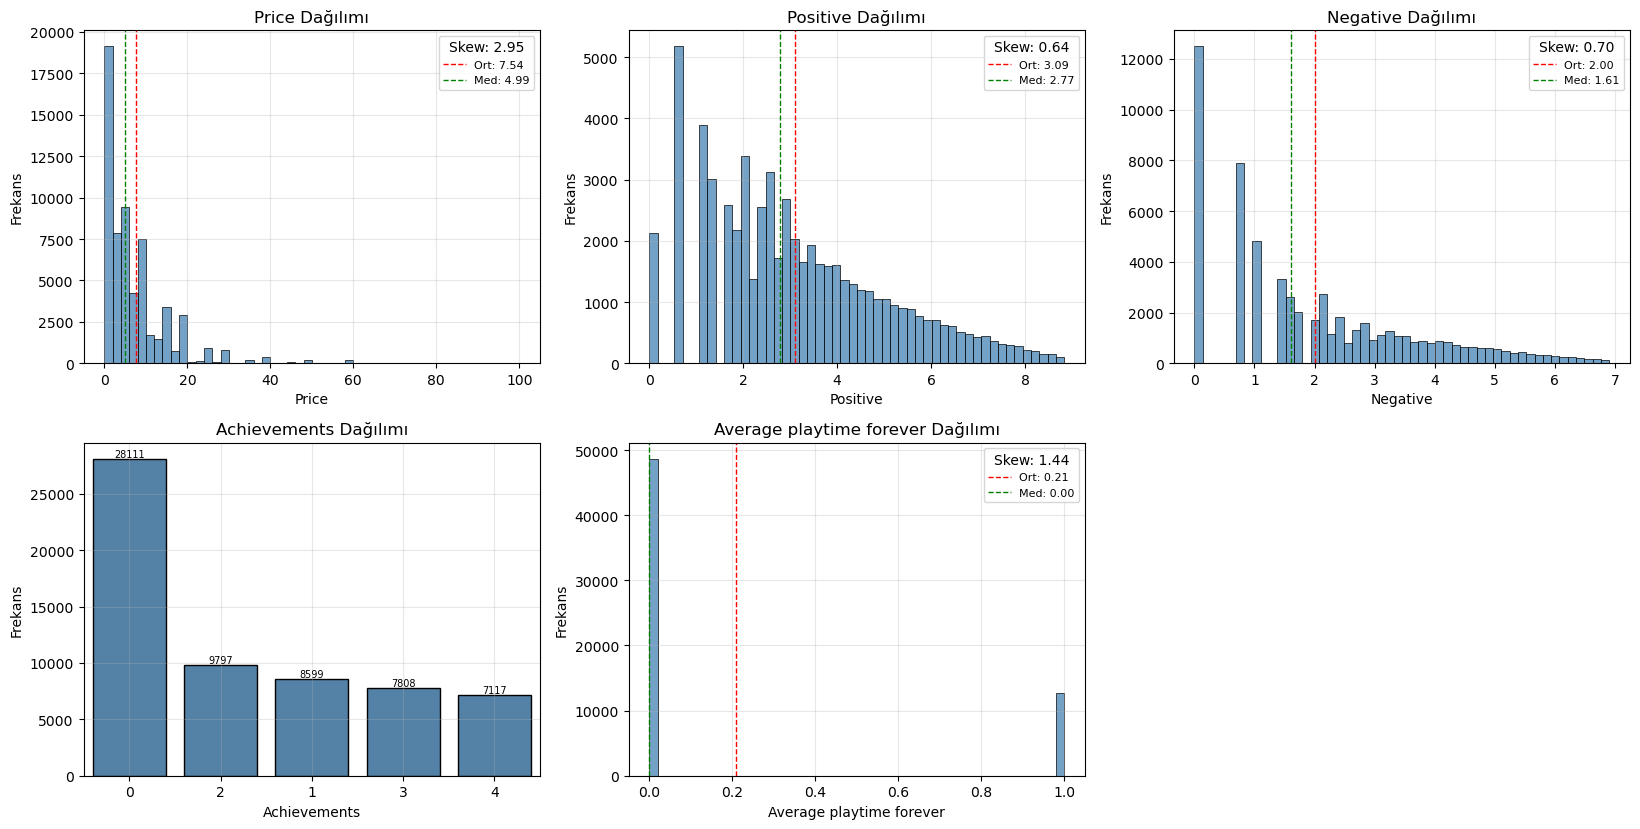

In [143]:

# Sadece istenen sütunların grafikleri
columns_of_interest = ['Price', 'Positive', 'Negative', 'Achievements', 'Average playtime forever']
present = [c for c in columns_of_interest if c in df.columns]

n = len(present)
cols_per_row = 3
rows = int(np.ceil(n / cols_per_row))
fig, axes = plt.subplots(rows, cols_per_row, figsize=(cols_per_row * 5.5, rows * 4.2))
axes = np.array(axes).reshape(-1)

for i, col in enumerate(present):
    ax = axes[i]
    s = df[col].dropna()

    if is_numeric_dtype(s):
        # Sayısal -> histogram + ort/med çizgileri
        sns.histplot(s, bins=50, kde=False, ax=ax, color='steelblue', edgecolor='black')
        mean_v, med_v = s.mean(), s.median()
        ax.axvline(mean_v, color='red', linestyle='--', linewidth=1, label=f"Ort: {mean_v:.2f}")
        ax.axvline(med_v, color='green', linestyle='--', linewidth=1, label=f"Med: {med_v:.2f}")
        try:
            skv = skew(s)
            lg = ax.legend(fontsize=8)
            if lg:
                lg.set_title(f"Skew: {skv:.2f}")
        except Exception:
            ax.legend(fontsize=8)
    else:
        # Kategorik -> countplot
        order = s.value_counts().index
        sns.countplot(x=s, order=order, ax=ax, color='steelblue', edgecolor='black')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
        # Çubukların üzerine sayıları yazalım
        for p in ax.patches:
            ax.annotate(f'{int(p.get_height())}', (p.get_x()+p.get_width()/2, p.get_height()),
                        ha='center', va='bottom', fontsize=7)

    ax.set_title(f"{col} Dağılımı")
    ax.set_xlabel(col)
    ax.set_ylabel('Frekans')
    ax.grid(alpha=0.3)

# Kullanılmayan eksenleri gizle
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


In [144]:
df.to_parquet("eda_data.parquet", index=False)

# Notebook 1 target 1 değeri ile
 - Estimated owners numeric: 40%
 - review_count: 35%
 - review_quality: 20%
 - Achievements: 5%

In [145]:

print("="*70)
print("GELİŞTİRİLMİŞ POPÜLERİTE SKORU (Playtime Olmadan)")
print("="*70)

# Veriyi yükle
df = pd.read_parquet("eda_data.parquet")
df2 = pd.read_parquet("popularity_score_old.parquet")
df['popularity_score_old'] = df2['popularity_score_old']

# Eski ağırlıklı skoru karşılaştırma için sakla
if 'popularity_score' in df.columns:
    df['popularity_score_old'] = df['popularity_score']
    print("Mevcut popularity_score 'popularity_score_old' olarak kopyalandı.")
else:
    print("Uyarı: 'popularity_score' bulunamadı; sadece yeni skor hesaplanacak.")


GELİŞTİRİLMİŞ POPÜLERİTE SKORU (Playtime Olmadan)
Uyarı: 'popularity_score' bulunamadı; sadece yeni skor hesaplanacak.


In [146]:
# Eksik sütunları hesapla
if 'review_count' not in df.columns:
    df['review_count'] = df['Positive'] + df['Negative']
    print("✓ review_count hesaplandı (Positive + Negative)")

if 'review_quality' not in df.columns:
    df['review_quality'] = df['Positive'] / (df['Positive'] + df['Negative'])
    df['review_quality'] = df['review_quality'].fillna(0)  # Hiç review yoksa 0
    print("✓ review_quality hesaplandı (Positive / Total)")

print(f"\n✓ Veri seti hazır. Şekil: {df.shape}")

✓ review_count hesaplandı (Positive + Negative)
✓ review_quality hesaplandı (Positive / Total)

✓ Veri seti hazır. Şekil: (61432, 46)


## Yeni Ağırlıkların Tanımı

Aşağıdaki ağırlık seti, playtime değişkenini dışarıda bırakarak daha saf bir popülarite ölçüsü üretmeyi hedefler.

- Estimated owners numeric: %40  (kitle büyüklüğü)
- review_count: %35 (ilgi / hacim)
- review_quality: %20 (memnuniyet oranı)
- Achievements: %5 (oyun derinliği / meta etkileşim)


In [147]:


# Yeni ağırlıklar (playtime hariç)
weights = {
    'Estimated owners numeric': 0.30,
    'review_count': 0.55,
    'review_quality': 0.20,
    'Achievements': 0.05
}

print("Yeni ağırlıklar:")
for f, w in weights.items():
    print(f"  - {f}: {w*100:.0f}%")


Yeni ağırlıklar:
  - Estimated owners numeric: 30%
  - review_count: 55%
  - review_quality: 20%
  - Achievements: 5%


## Skorun Hesaplanması

Özellikler tek tek 0-1 aralığına ölçeklenir (Min-Max) ve ağırlıklarla toplanır. Mevcut normalize sütunlar varsa kullanılır, yoksa yerinde üretilir.

In [148]:
from sklearn.preprocessing import MinMaxScaler

# Normalize edilmiş değerleri kullan (zaten mevcutsa yeniden üretme)
if 'popularity_score_new' in df.columns:
    df.drop(columns=['popularity_score_new'], inplace=True)

df['popularity_score_new'] = 0.0

for feature, weight in weights.items():
    norm_col = f"{feature}_normalized"
    if norm_col in df.columns:
        df['popularity_score_new'] += df[norm_col] * weight
    else:
        # Min-Max normalize et
        col_min = df[feature].min()
        col_max = df[feature].max()
        if col_max == col_min:
            df[norm_col] = 0.0
        else:
            df[norm_col] = (df[feature] - col_min) / (col_max - col_min)
        df['popularity_score_new'] += df[norm_col] * weight

print("Yeni popülerlik skoru hesaplandı.")
print(f"  Min:      {df['popularity_score_new'].min():.4f}")
print(f"  Maks:     {df['popularity_score_new'].max():.4f}")
print(f"  Ortalama: {df['popularity_score_new'].mean():.4f}")
print(f"  Medyan:   {df['popularity_score_new'].median():.4f}")


Yeni popülerlik skoru hesaplandı.
  Min:      0.0000
  Maks:     0.9222
  Ortalama: 0.3098
  Medyan:   0.2870


## Yeni Target Oluşturma

Yeni skora göre Low/Medium/High kesimleri %33'lük quantile'lara göre atanır.

In [149]:
q33_new = df['popularity_score_new'].quantile(0.33)
q66_new = df['popularity_score_new'].quantile(0.66)

df['target_new'] = pd.cut(
    df['popularity_score_new'],
    bins=[-np.inf, q33_new, q66_new, np.inf],
    labels=[0,1,2]
)

print("Yeni target dağılımı:")
print(df['target_new'].value_counts().sort_index())


Yeni target dağılımı:
target_new
0    20278
1    20268
2    20886
Name: count, dtype: int64


## Eski-Yeni Karşılaştırma

Eski skor (playtime dahil) ile yeni skorun (playtime hariç) ayrıştırma gücü ve kategori geçişlerini karşılaştırıyoruz.

Grafik kaydedildi: playtime_comparison.png


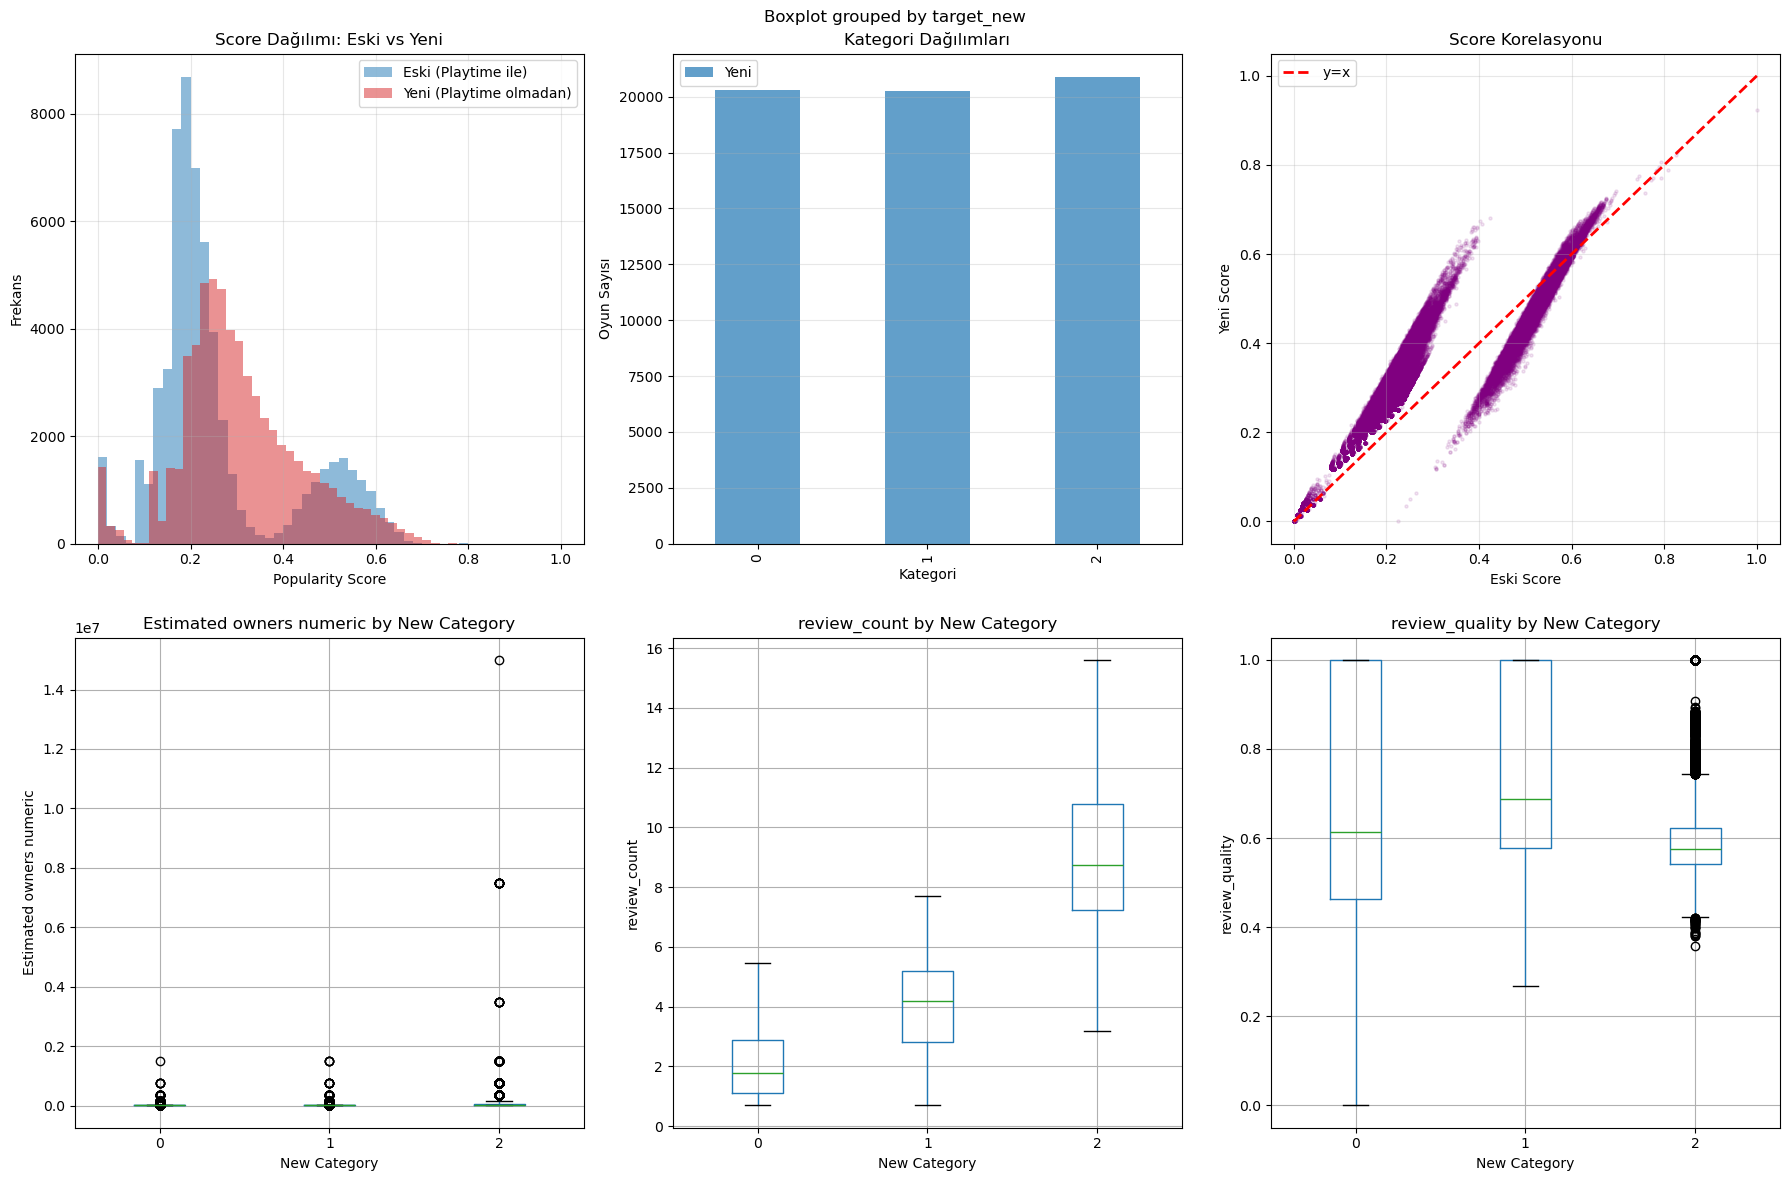

In [150]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Score dağılımı karşılaştırma
if 'popularity_score_old' in df.columns:
    axes[0, 0].hist(df['popularity_score_old'], bins=50, alpha=0.5, label='Eski (Playtime ile)', color='tab:blue')
axes[0, 0].hist(df['popularity_score_new'], bins=50, alpha=0.5, label='Yeni (Playtime olmadan)', color='tab:red')
axes[0, 0].set_xlabel('Popularity Score')
axes[0, 0].set_ylabel('Frekans')
axes[0, 0].set_title('Score Dağılımı: Eski vs Yeni')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# 2. Kategori dağılımları
if 'target' in df.columns:
    cat_compare = pd.DataFrame({
        'Eski': df['target'].value_counts().sort_index(),
        'Yeni': df['target_new'].value_counts().sort_index()
    })
else:
    cat_compare = pd.DataFrame({'Yeni': df['target_new'].value_counts().sort_index()})
cat_compare.plot(kind='bar', ax=axes[0, 1], color=['tab:blue', 'tab:red'][:len(cat_compare.columns)], alpha=0.7)
axes[0, 1].set_xlabel('Kategori')
axes[0, 1].set_ylabel('Oyun Sayısı')
axes[0, 1].set_title('Kategori Dağılımları')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Scatter: Eski vs Yeni Score
if 'popularity_score_old' in df.columns:
    axes[0, 2].scatter(df['popularity_score_old'], df['popularity_score_new'], alpha=0.1, s=5, color='purple')
    axes[0, 2].plot([0, 1], [0, 1], 'r--', linewidth=2, label='y=x')
    axes[0, 2].set_xlabel('Eski Score')
    axes[0, 2].set_ylabel('Yeni Score')
    axes[0, 2].set_title('Score Korelasyonu')
    axes[0, 2].legend()
    axes[0, 2].grid(alpha=0.3)
else:
    axes[0, 2].axis('off')

# 4-6. Box plots: Yeni kategorilerin feature dağılımları
features_to_plot = ['Estimated owners numeric', 'review_count', 'review_quality']
for idx, feature in enumerate(features_to_plot):
    ax = axes[1, idx]
    try:
        df.boxplot(column=feature, by='target_new', ax=ax)
        ax.set_title(f'{feature} by New Category')
        ax.set_xlabel('New Category')
        ax.set_ylabel(feature)
        plt.sca(ax)
        plt.xticks(rotation=0)
    except Exception as e:
        ax.text(0.5, 0.5, f'Plotlanamadı: {feature}\n{e}', ha='center', va='center')
        ax.axis('off')

plt.tight_layout()
plt.savefig('playtime_comparison.png', dpi=300, bbox_inches='tight')
print("Grafik kaydedildi: playtime_comparison.png")

## Target(Data) Lakage Önlemi

Target lakage önlemek için target'da kullandığımız özellikleri veri setinden çıkaralım.

In [151]:
# Target'ı oluştururken kullanılan sütunları çıkar (data leakage önleme)
columns_to_drop = [
    'Estimated owners numeric',
    'review_count', 
    'review_quality',
    'Achievements',
    'popularity_score_new',
    'popularity_score_old',
    'popularity_score',
    'target',
    'Estimated owners' # eski target
]

# Normalize edilmiş sütunları da çıkar
normalized_cols = [col for col in df.columns if col.endswith('_normalized')]
columns_to_drop.extend(normalized_cols)

# Mevcut olan sütunları çıkar
cols_to_drop_existing = [col for col in columns_to_drop if col in df.columns]
df_for_modeling = df.drop(columns=cols_to_drop_existing)

print(f"Çıkarılan sütunlar ({len(cols_to_drop_existing)}):")
for col in cols_to_drop_existing:
    print(f"  - {col}")

print(f"\nKalan sütun sayısı: {df_for_modeling.shape[1]}")
print(f"Satır sayısı: {df_for_modeling.shape[0]}")

# Kaydet
output_path = "target1_data.parquet"
cols_to_check = ['target_new']
if all(c in df_for_modeling.columns for c in cols_to_check):
    df_for_modeling.to_parquet(output_path)
    print(f"\n✓ Veri kaydedildi: {output_path}")
    print(f"  Target sütunu: target_new")
    print(f"  Feature sayısı: {df_for_modeling.shape[1] - 1}")  # target hariç
else:
    print("Gerekli sütunlar eksik, kaydetme atlandı.")

Çıkarılan sütunlar (11):
  - Estimated owners numeric
  - review_count
  - review_quality
  - Achievements
  - popularity_score_new
  - popularity_score_old
  - Estimated owners
  - Estimated owners numeric_normalized
  - review_count_normalized
  - review_quality_normalized
  - Achievements_normalized

Kalan sütun sayısı: 41
Satır sayısı: 61432

✓ Veri kaydedildi: target1_data.parquet
  Target sütunu: target_new
  Feature sayısı: 40


# Notebook 2 target 2 
sadece Estimetid owner kullanarak hesapladığımız target değeri ile


In [152]:

# 1. VERİYİ YÜKLE
df = pd.read_parquet("eda_data.parquet")

print(f"Orjinal veri boyutu: {df.shape}")

# 2. TARGET OLUŞTUR
def categorize_owners(owner_range):
    """
    Estimated owners aralığını 3 kategoriye ayırır
    Low: 0 - 20000
    Medium: 20000 - 50000
    High: 50000+
    """
    if pd.isna(owner_range):
        return None
    
    owner_str = str(owner_range).strip()
    
    # Düşük popülerlik
    if owner_str in ['0 - 0', '0 - 20000']:
        return 0  # Low
    
    # Orta popülerlik
    elif owner_str == '20000 - 50000':
        return 1  # Medium
    
    # Yüksek popülerlik (50000'den büyük her şey)
    else:
        try:
            lower_bound = int(owner_str.split(' - ')[0])
            if lower_bound >= 50000:
                return 2  # High
            else:
                return 1  # Medium
        except:
            return None

# Target kolonunu oluştur
df['target'] = df['Estimated owners'].apply(categorize_owners)

# Missing değerleri kontrol et
print(f"\nTarget missing değer sayısı: {df['target'].isna().sum()}")

# Missing varsa temizle
df_final = df[df['target'].notna()].copy()

print(f"\nTemizlenmiş veri boyutu: {df_final.shape}")

# Dağılımı kontrol et
print("\n=== TARGET DAĞILIMI ===")
print(df_final['target'].value_counts().sort_index())
print(f"\nYüzdeler:")
print(df_final['target'].value_counts(normalize=True).sort_index() * 100)

# Mapping bilgisi
print("\n=== TARGET KODLAMA ===")
print("0 = Low (0-20000)")
print("1 = Medium (20000-50000)")
print("2 = High (50000+)")

# 3. KAYDEDİLECEK VERİYİ HAZIRLA
# Estimated owners kolonunu çıkar (artık target var)
df_final = df_final.drop(columns=['Estimated owners','Estimated owners numeric'], errors='ignore')

print(f"\n Final veri kolonları: {df_final.shape[1]}")
print(f" Final veri satırları: {df_final.shape[0]}")

# 4. KAYDET
output_filename = "target2_data.parquet"
df_final.to_parquet(output_filename, index=False)

print(f"\n VERİ KAYDEDİLDİ: '{output_filename}'")
print(f"\nKullanım:")
print(f"  df = pd.read_parquet('{output_filename}')")
print(f"  X = df.drop(columns=['target'])")
print(f"  y = df['target']")

# Özet bilgi
print("\n" + "="*60)
print("ÖZET BİLGİ")
print("="*60)
print(f"Toplam satır: {len(df_final)}")
print(f"Toplam kolon: {len(df_final.columns)}")
print(f"Target kolon: 'target'")
print(f"  - 0 (Low):    {(df_final['target']==0).sum():,} örneg")
print(f"  - 1 (Medium): {(df_final['target']==1).sum():,} örnek")
print(f"  - 2 (High):   {(df_final['target']==2).sum():,} örnek")
print("="*60)

Orjinal veri boyutu: (61432, 43)

Target missing değer sayısı: 0

Temizlenmiş veri boyutu: (61432, 44)

=== TARGET DAĞILIMI ===
target
0    45099
1     7753
2     8580
Name: count, dtype: int64

Yüzdeler:
target
0    73.412879
1    12.620458
2    13.966662
Name: proportion, dtype: float64

=== TARGET KODLAMA ===
0 = Low (0-20000)
1 = Medium (20000-50000)
2 = High (50000+)

 Final veri kolonları: 42
 Final veri satırları: 61432

 VERİ KAYDEDİLDİ: 'target2_data.parquet'

Kullanım:
  df = pd.read_parquet('target2_data.parquet')
  X = df.drop(columns=['target'])
  y = df['target']

ÖZET BİLGİ
Toplam satır: 61432
Toplam kolon: 42
Target kolon: 'target'
  - 0 (Low):    45,099 örneg
  - 1 (Medium): 7,753 örnek
  - 2 (High):   8,580 örnek



 Grafik kaydedildi: target_distribution.png


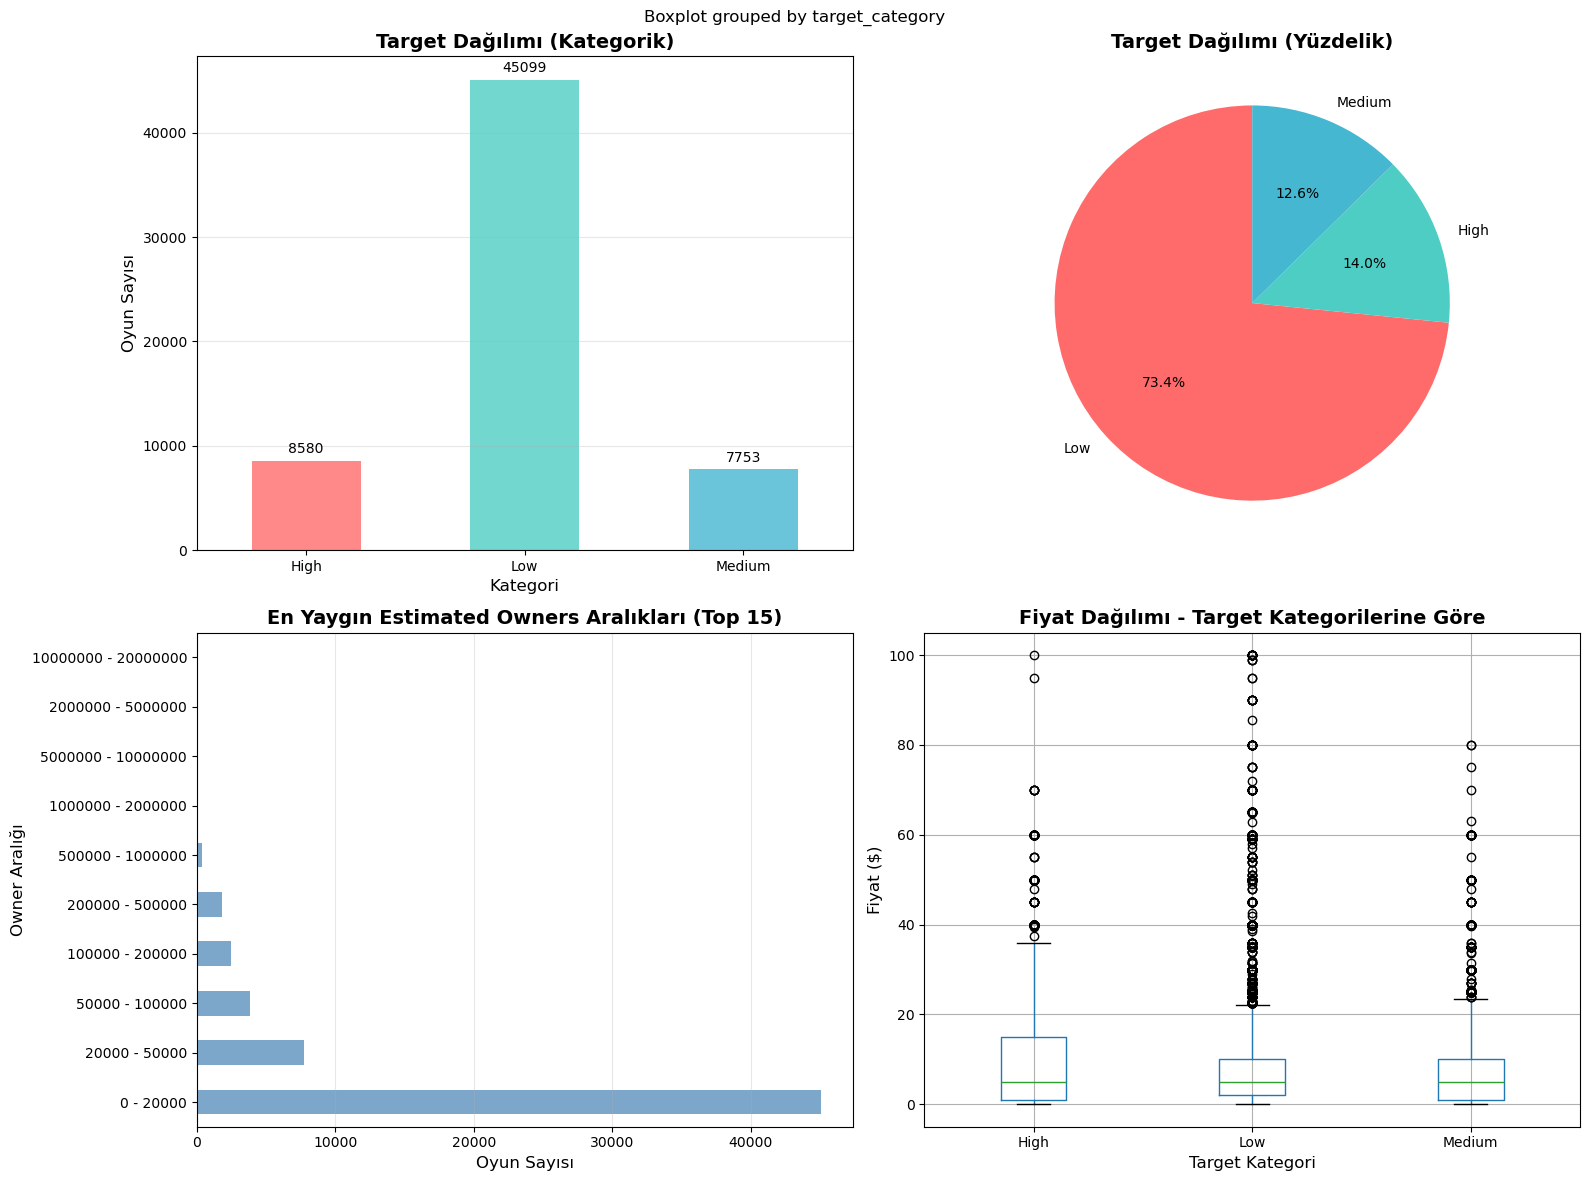


TARGET İSTATİSTİKLERİ

Toplam veri sayısı: 61,432
Temiz veri sayısı: 61,432

Kategori dağılımı:
  Low     : 45,099 (73.41%)
  Medium  :  7,753 (12.62%)
  High    :  8,580 (13.97%)


In [153]:

# Görselleştirmeler
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Target Dağılımı - Bar Chart
y_categorical.value_counts().sort_index().plot(kind='bar', ax=axes[0, 0], color=['#FF6B6B', '#4ECDC4', '#45B7D1'], alpha=0.8)
axes[0, 0].set_title('Target Dağılımı (Kategorik)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Kategori', fontsize=12)
axes[0, 0].set_ylabel('Oyun Sayısı', fontsize=12)
axes[0, 0].grid(axis='y', alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=0)

# Değerleri çubukların üzerine yaz
for container in axes[0, 0].containers:
    axes[0, 0].bar_label(container, fmt='%d', padding=3)

# 2. Target Dağılımı - Pie Chart
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
y_categorical.value_counts().plot(kind='pie', ax=axes[0, 1], autopct='%1.1f%%', 
                                   colors=colors, startangle=90)
axes[0, 1].set_title('Target Dağılımı (Yüzdelik)', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('')

# 3. Estimated Owners Dağılımı
owner_counts = df['Estimated owners'].value_counts().head(15)
owner_counts.plot(kind='barh', ax=axes[1, 0], color='steelblue', alpha=0.7)
axes[1, 0].set_title('En Yaygın Estimated Owners Aralıkları (Top 15)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Oyun Sayısı', fontsize=12)
axes[1, 0].set_ylabel('Owner Aralığı', fontsize=12)
axes[1, 0].grid(axis='x', alpha=0.3)

# 4. Target'a göre sayısal özelliklerin dağılımı (örnek: Price)
if 'Price' in df_clean.columns:
    df_clean_with_target = df_clean.copy()
    df_clean_with_target['target_category'] = y_categorical[y.notna()]
    
    df_clean_with_target.boxplot(column='Price', by='target_category', ax=axes[1, 1])
    axes[1, 1].set_title('Fiyat Dağılımı - Target Kategorilerine Göre', fontsize=14, fontweight='bold')
    axes[1, 1].set_xlabel('Target Kategori', fontsize=12)
    axes[1, 1].set_ylabel('Fiyat ($)', fontsize=12)
    plt.sca(axes[1, 1])
    plt.xticks(rotation=0)
else:
    # Alternatif: Target kategorilerine göre Achievements
    if 'Achievements' in df_clean.columns:
        df_clean_with_target = df_clean.copy()
        df_clean_with_target['target_category'] = y_categorical[y.notna()]
        
        df_clean_with_target.boxplot(column='Achievements', by='target_category', ax=axes[1, 1])
        axes[1, 1].set_title('Achievements Dağılımı - Target Kategorilerine Göre', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Target Kategori', fontsize=12)
        axes[1, 1].set_ylabel('Achievements Sayısı', fontsize=12)

plt.tight_layout()
plt.savefig('target_distribution.png', dpi=300, bbox_inches='tight')
print("\n Grafik kaydedildi: target_distribution.png")
plt.show()

# Ek: Korelasyon Analizi
print("\n" + "="*70)
print("TARGET İSTATİSTİKLERİ")
print("="*70)
print(f"\nToplam veri sayısı: {len(df):,}")
print(f"Temiz veri sayısı: {len(df_clean):,}")
print(f"\nKategori dağılımı:")
for cat in ['Low', 'Medium', 'High']:
    count = (y_categorical == cat).sum()
    pct = count / len(y_categorical) * 100
    print(f"  {cat:8s}: {count:6,} ({pct:5.2f}%)")